In [3]:
# Installation des dépendances nécessaires
!pip install -q imbalanced-learn xgboost


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 🌍 Mini-projet 6 : Classification de la stabilité des terrains (Risque de glissement)

## 👥 Membres du Groupe
Ce projet a été réalisé en collaboration par :
- **Mohamed Driouch**
- **Youness Roubai**
- **Marouane Bakali**
- **COULIBALY Cheickna Hamala**

## 📌 Description du Projet
Ce projet s'inscrit dans le cadre de notre cours d'Apprentissage Supervisé. L'objectif principal est de mettre en œuvre un processus complet de Machine Learning pour classifier des zones géographiques selon leur niveau de stabilité, afin d'identifier les zones à risque de glissement de terrain.

## 📊 Données
Le modèle est entraîné sur le dataset `geo_stabilite_terrain_data.csv`. Les variables explicatives incluent des données topographiques (pente, altitude), géologiques (texture du sol, distance aux failles, indice géotechnique) et environnementales (humidité, couverture végétale).
- **Variable Cible :** `stabilite_terrain` (Classes : *stable, moyennement stable, instable*).

## ⚙️ Modélisation et Modèles Évalués
Afin de trouver la meilleure solution de classification et de comparer les performances, nous avons implémenté et optimisé les modèles de Machine Learning suivants :
1. **XGBoost Classifier** (Extreme Gradient Boosting)
2. **CatBoost Classifier**
3. **LightGBM** (Light Gradient Boosting Machine)
4. **Random Forest Classifier**
5. **Support Vector Machine (SVM)**

## 🚀 Étapes Principales du Projet
- **Analyse Exploratoire des Données (EDA) :** Visualisation des distributions, analyse des valeurs manquantes et cartographie spatiale.
- **Prétraitement :** Nettoyage des données, traitement des valeurs manquantes, encodage des variables catégorielles et standardisation.
- **Modélisation :** Séparation des données (Train/Test) et entraînement des différents modèles.
- **Optimisation :** Recherche des meilleurs hyperparamètres pour maximiser les performances.
- **Évaluation :** Comparaison des modèles via la Matrice de confusion, l'Accuracy, la Précision, le Recall et le F1-score.

---
## 1. Import des bibliothèques

In [4]:
# Bibliothèques standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_score, recall_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE

# Paramètres d'affichage 
# améliore l’esthétique des graphiques seaborn
sns.set_theme(style='whitegrid', palette='muted')
# Configure Pandas pour afficher jusqu’à 20 colonnes dans les DataFrames.
pd.set_option('display.max_columns', 20)
# Définit le format d’affichage des nombres flottants.
pd.set_option('display.float_format', '{:.3f}'.format)
print(' Bibliothèques importées avec succès.')


 Bibliothèques importées avec succès.


---
## 2. Chargement et première exploration des données

In [5]:
# Chargement du fichier CSV
df = pd.read_csv('geo_stabilite_terrain_data.csv')

print(f' Dimensions : {df.shape[0]} lignes × {df.shape[1]} colonnes')
print('\n Aperçu des 5 premières lignes :')
display(df.head())

 Dimensions : 1549 lignes × 11 colonnes

 Aperçu des 5 premières lignes :


,pente_pct,altitude_m,texture_sol,humidite_sol,distance_faille_km,couverture_vegetale,longitude,latitude,zone_id,stabilite_terrain,indice_geotech_labo
0,14.982,640.305,0.488,42.207,6.767,0.708,-6.259,34.430,427,Moyennement_stable,NaN
1,38.029,845.545,0.402,26.104,0.120,0.268,-6.549,34.861,344,MOY_STABLE,NaN
2,29.280,622.540,0.154,15.356,0.988,0.205,-6.203,34.570,507,moyennement stable,NaN
3,23.946,522.707,0.573,7.113,10.581,0.527,-5.632,35.252,341,Moyennement_stable,NaN
4,6.241,622.014,0.277,34.043,NaN,0.311,-6.538,35.193,321,Moyennement_stable,NaN


In [6]:
# Informations générales : types, valeurs non-nulles
print(' Informations générales :')
df.info()
print('\n Statistiques descriptives :')
display(df.describe(include='all'))

 Informations générales :
<class 'pandas.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pente_pct            1455 non-null   float64
 1   altitude_m           1501 non-null   float64
 2   texture_sol          1417 non-null   float64
 3   humidite_sol         1443 non-null   float64
 4   distance_faille_km   1486 non-null   float64
 5   couverture_vegetale  1455 non-null   float64
 6   longitude            1549 non-null   float64
 7   latitude             1549 non-null   float64
 8   zone_id              1549 non-null   int64  
 9   stabilite_terrain    1548 non-null   str    
 10  indice_geotech_labo  156 non-null    float64
dtypes: float64(9), int64(1), str(1)
memory usage: 133.2 KB

 Statistiques descriptives :


,pente_pct,altitude_m,texture_sol,humidite_sol,distance_faille_km,couverture_vegetale,longitude,latitude,zone_id,stabilite_terrain,indice_geotech_labo
count,1455.000,1501.000,1417.000,1443.000,1486.000,1455.000,1549.000,1549.000,1549.000,1548,156.000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moyennement_stable,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,NaN
mean,19.914,608.527,0.491,24.753,5.877,0.488,-5.939,34.995,362.593,NaN,0.551
std,11.727,176.182,0.287,11.592,3.414,0.253,0.373,0.351,92.572,NaN,0.135
min,0.185,70.730,0.000,5.157,0.053,0.050,-6.600,34.400,200.000,NaN,0.172
25%,9.516,486.733,0.237,14.742,2.974,0.277,-6.264,34.689,283.000,NaN,0.466
50%,20.137,606.883,0.483,24.641,5.804,0.479,-5.934,34.979,362.000,NaN,0.539
75%,29.992,724.725,0.739,34.700,8.769,0.698,-5.616,35.309,442.000,NaN,0.637


> Interprétation : On observe le type de chaque colonne et les premières valeurs manquantes éventuelles.  
> La colonne `texture_sol` peut être numérique ou catégorielle selon la nature de l'encodage initial.
> On vérifiera cela lors du prétraitement.


3. Analyse Exploratoire des Données (EDA) - Avant prétraitement

  Valeurs manquantes détectées :


,Nb manquantes,% manquantes
indice_geotech_labo,1393,89.929
texture_sol,132,8.522
humidite_sol,106,6.843
pente_pct,94,6.068
couverture_vegetale,94,6.068
distance_faille_km,63,4.067
altitude_m,48,3.099
stabilite_terrain,1,0.065


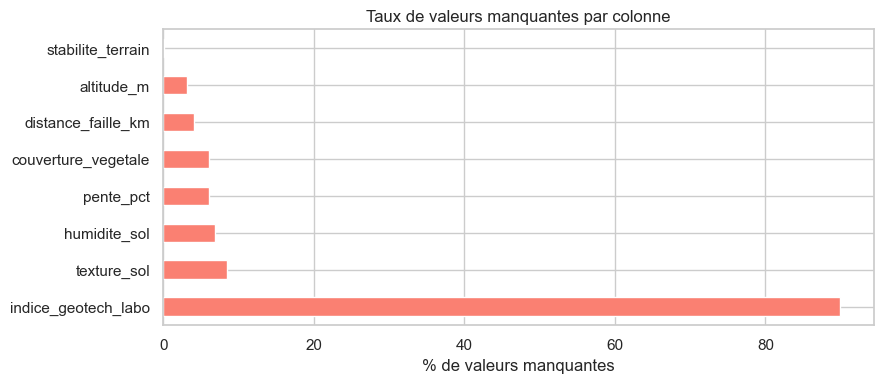

In [7]:
# 3.1 Valeurs manquantes 
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({'Nb manquantes': missing, '% manquantes': missing_pct})
missing_df = missing_df[missing_df['Nb manquantes'] > 0].sort_values('% manquantes', ascending=False)

if missing_df.empty:
    print(' Aucune valeur manquante détectée.')
else:
    print('  Valeurs manquantes détectées :')
    display(missing_df)

    # Visualisation
    fig, ax = plt.subplots(figsize=(9, 4))
    missing_df['% manquantes'].plot(kind='barh', ax=ax, color='salmon')
    ax.set_xlabel('% de valeurs manquantes')
    ax.set_title('Taux de valeurs manquantes par colonne')
    plt.tight_layout()
    plt.show()

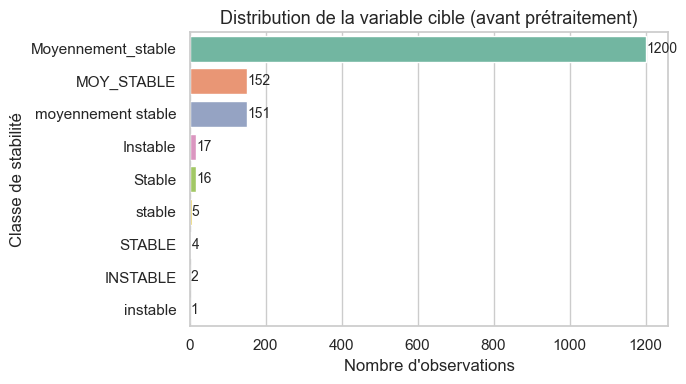

stabilite_terrain
Moyennement_stable    1200
MOY_STABLE             152
moyennement stable     151
Instable                17
Stable                  16
stable                   5
STABLE                   4
INSTABLE                 2
instable                 1
Name: count, dtype: int64


In [8]:
# 3.2 Distribution de la variable cible
fig, ax = plt.subplots(figsize=(7, 4))
order = df['stabilite_terrain'].value_counts().index
sns.countplot(data=df, y='stabilite_terrain', order=order, ax=ax, palette='Set2')
ax.set_title('Distribution de la variable cible (avant prétraitement)', fontsize=13)
ax.set_xlabel('Nombre d\'observations')
ax.set_ylabel('Classe de stabilité')
for p in ax.patches:
    ax.text(p.get_width() + 1, p.get_y() + p.get_height()/2,
            f'{int(p.get_width())}', va='center', fontsize=10)
plt.tight_layout()
plt.show()
print(df['stabilite_terrain'].value_counts())

> Interprétation : Si une classe est sur-représentée (ex. 'stable' >> 'instable'), cela constitue un déséquilibre de classes.  
> Pour y remédier, on utilisera le paramètre " class_weight='balanced' " dans notre modèles, ce qui attribue un poids inversement proportionnel à la fréquence de chaque classe.

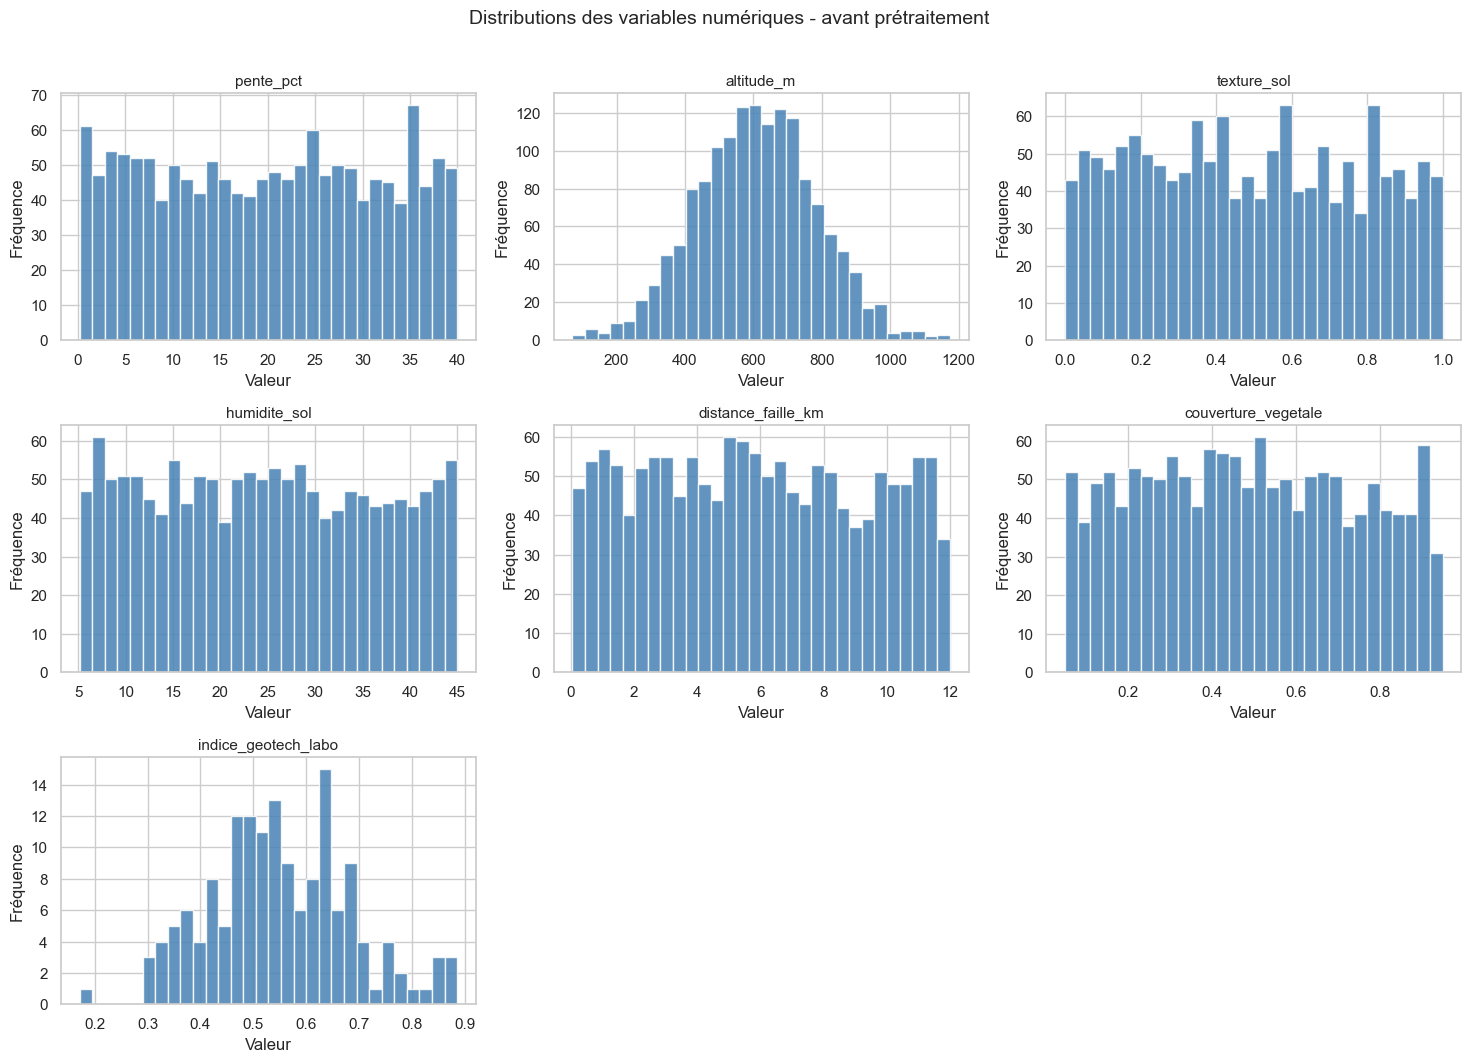

In [9]:
#3.3 Distribution des variables numériques (histogrammes) 
spatial_cols = ['latitude', 'longitude', 'zone_id']
num_cols = [c for c in df.select_dtypes(include=np.number).columns if c not in spatial_cols]

n = len(num_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3.5))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    axes[i].hist(df[col].dropna(), bins=30, color='steelblue', edgecolor='white', alpha=0.85)
    axes[i].set_title(col, fontsize=11)
    axes[i].set_xlabel('Valeur')
    axes[i].set_ylabel('Fréquence')
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
fig.suptitle('Distributions des variables numériques - avant prétraitement', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

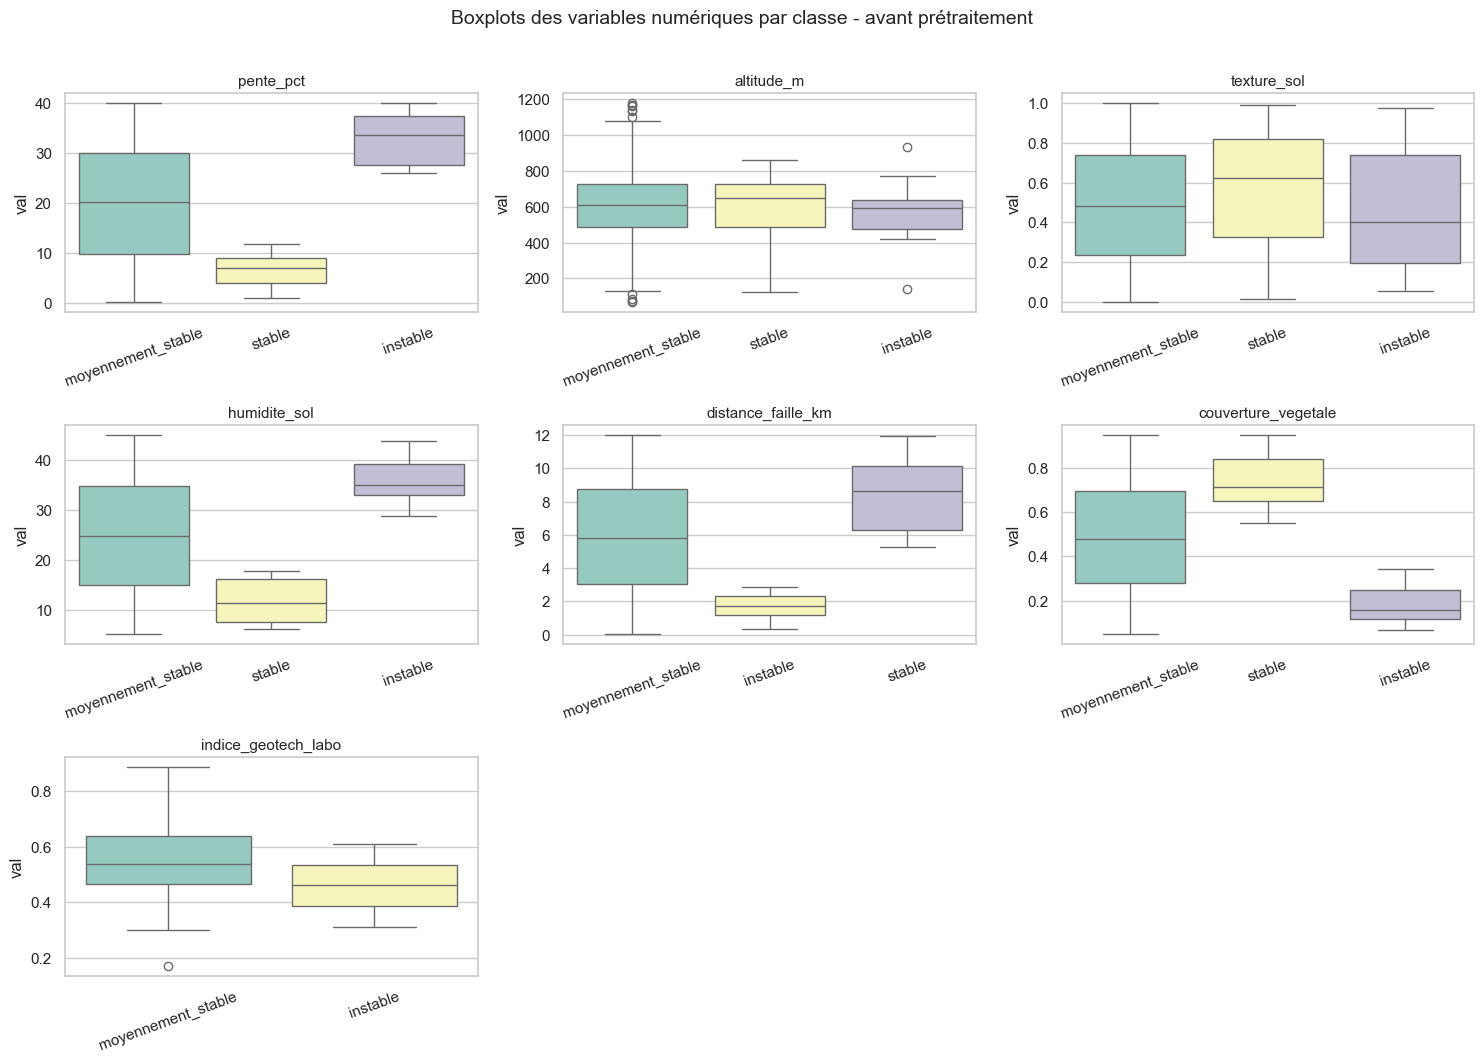

In [10]:
#  3.4 Boxplots par classe (détection d'outliers et discrimination)
target_clean_tmp = df['stabilite_terrain'].str.strip().str.lower().replace(
    {'moy_stable': 'moyennement_stable', 'moyennement stable': 'moyennement_stable'}
)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3.5))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    tmp = pd.DataFrame({'val': df[col], 'classe': target_clean_tmp}).dropna()
    sns.boxplot(data=tmp, x='classe', y='val', palette='Set3', ax=axes[i])
    axes[i].set_title(col, fontsize=11)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=20)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
fig.suptitle('Boxplots des variables numériques par classe - avant prétraitement', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

> Interprétation : Les boxplots permettent de :
> - Détecter des valeurs aberrantes (points au-delà des moustaches)
> - Évaluer la capacité discriminante de chaque variable : si les distributions diffèrent selon la classe, la variable est informative.
> - Par exemple, on s'attend à ce que `pente_pct` et `humidite_sol` soient plus élevées pour les zones instables.

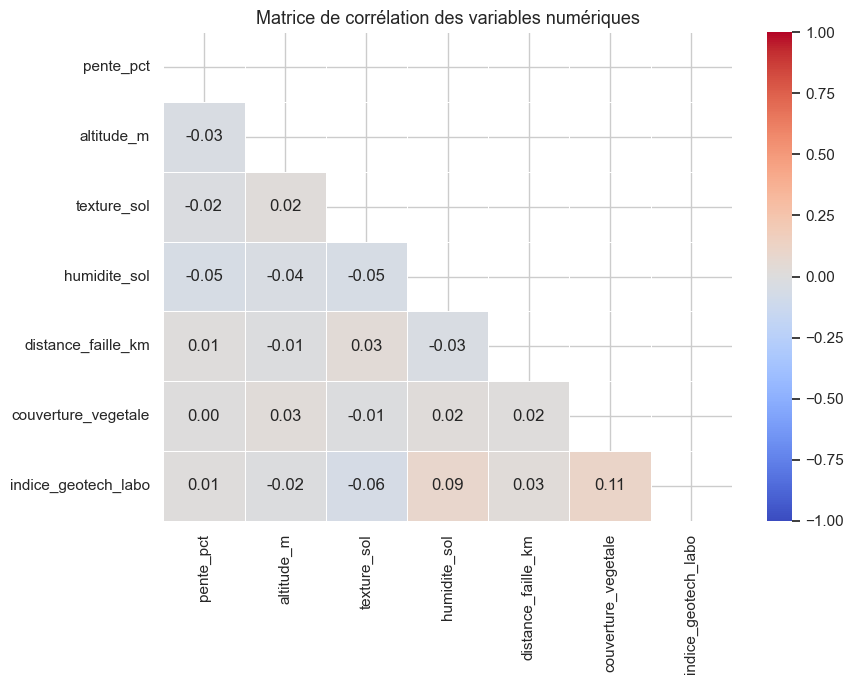

In [11]:
# 3.5 Matrice de corrélation 
corr_matrix = df[num_cols].corr()
fig, ax = plt.subplots(figsize=(9, 7))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt='.2f',
    cmap='coolwarm', center=0, vmin=-1, vmax=1,
    linewidths=0.5, ax=ax
)
ax.set_title('Matrice de corrélation des variables numériques', fontsize=13)
plt.tight_layout()
plt.show()

> Interprétation : Une corrélation forte entre deux variables explicatives (> 0.8 ou < -0.8) indique une multicolinéarité potentielle.  

---
## 4. Prétraitement des données

In [12]:
#  4.1 Harmonisation des noms de colonnes 
df.columns = df.columns.str.strip().str.lower()
print(' Colonnes harmonisées :', df.columns.tolist())

 Colonnes harmonisées : ['pente_pct', 'altitude_m', 'texture_sol', 'humidite_sol', 'distance_faille_km', 'couverture_vegetale', 'longitude', 'latitude', 'zone_id', 'stabilite_terrain', 'indice_geotech_labo']


In [13]:
#  4.2 Nettoyage et harmonisation de la variable cible 
# les modalités peuvent avoir des espaces ou des variantes (ex. 'moy_stable' au lieu de 'moyennement_stable')
df['stabilite_terrain'] = df['stabilite_terrain'].str.strip().str.lower()
mapping_target = {
    'moy_stable'          : 'moyennement_stable',
    'moyennement stable'  : 'moyennement_stable',
    'moyennement_stable'  : 'moyennement_stable',
    'stable'              : 'stable',
    'instable'            : 'instable'
}
df['stabilite_terrain'] = df['stabilite_terrain'].replace(mapping_target)

# Suppression des lignes à cible manquante ou non reconnue
valid_classes = {'stable', 'moyennement_stable', 'instable'}
n_before = len(df)
df = df[df['stabilite_terrain'].isin(valid_classes)]
print(f' Lignes supprimées (cible invalide ou manquante) : {n_before - len(df)}')
print('Distribution après harmonisation :')
print(df['stabilite_terrain'].value_counts())

 Lignes supprimées (cible invalide ou manquante) : 1
Distribution après harmonisation :
stabilite_terrain
moyennement_stable    1503
stable                  25
instable                20
Name: count, dtype: int64


In [14]:
#  4.3 Suppression des variables spatiales. latitude, longitude et zone_id sont des identifiants spatiaux. Les inclure dans le modèle induirait un sur-apprentissage lié à la géographie plutôt qu'aux caractéristiques intrinsèques du terrain.Ils sont conservés uniquement pour les visualisations.
spatial_cols = [c for c in ['latitude', 'longitude', 'zone_id'] if c in df.columns]
df_model = df.drop(columns=spatial_cols)
print(f' Variables spatiales supprimées : {spatial_cols}')
print(f' Dimensions après suppression : {df_model.shape}')

 Variables spatiales supprimées : ['latitude', 'longitude', 'zone_id']
 Dimensions après suppression : (1548, 8)


In [15]:
# 4.4 Détection et suppression des doublons 
n_dup = df_model.duplicated().sum()
print(f' Nombre de doublons détectés : {n_dup}')
if n_dup > 0:
    df_model = df_model.drop_duplicates()
    print(f' Doublons supprimés. Nouvelles dimensions : {df_model.shape}')
else:
    print(' Aucun doublon.')

 Nombre de doublons détectés : 3
 Doublons supprimés. Nouvelles dimensions : (1545, 8)


In [16]:
#  4.5 Séparation features / cible et identification des types 
y_raw = df_model['stabilite_terrain']
X_raw = df_model[['pente_pct','altitude_m','texture_sol','humidite_sol','distance_faille_km','couverture_vegetale']]

# Identifier colonnes numériques et catégorielles
cat_cols = X_raw.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols_model = X_raw.select_dtypes(include=np.number).columns.tolist()

print(f'Variables numériques  ({len(num_cols_model)}) : {num_cols_model}')
print(f'Variables catégorielles ({len(cat_cols)}) : {cat_cols}')

Variables numériques  (6) : ['pente_pct', 'altitude_m', 'texture_sol', 'humidite_sol', 'distance_faille_km', 'couverture_vegetale']
Variables catégorielles (0) : []


In [17]:
#  4.6 Encodage de la variable cible
# Le SVC attend des étiquettes numériques. On utilise LabelEncoder pour conserver la correspondance classe <-> code.
le = LabelEncoder()
y = le.fit_transform(y_raw)
print('Correspondance classes -> codes :')
for cls, code in zip(le.classes_, le.transform(le.classes_)):
    print(f'  {cls} -> {code}')

Correspondance classes -> codes :
  instable -> 0
  moyennement_stable -> 1
  stable -> 2


In [18]:
#  4.7 Suppression des colonnes trop manquantes (seuil 50%) 
# une colonne avec > 50 % de valeurs manquantes apporte peu d'information et toute imputation serait artificiellement dominante.

thresh = 0.5
missing_ratio = X_raw.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > thresh].index.tolist()
if cols_to_drop:
    print(f'  Colonnes supprimées (> {thresh*100:.0f}% manquants) : {cols_to_drop}')
    X_raw = X_raw.drop(columns=cols_to_drop)
    cat_cols = [c for c in cat_cols if c not in cols_to_drop]
    num_cols_model = [c for c in num_cols_model if c not in cols_to_drop]
else:
    print(' Aucune colonne supprimée pour excès de valeurs manquantes.')

 Aucune colonne supprimée pour excès de valeurs manquantes.


In [19]:
# 4.8 Construction du pipeline de prétraitement 
# Colonnes numériques : imputation par médiane(robuste aux valeurs aberrantes) + standardisation(SVM est sensible à l'échelle des features)
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Colonnes catégorielles : imputation + encodage ordinal
if cat_cols:
    cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])
    preprocessor = ColumnTransformer([
        ('num', num_transformer, num_cols_model),
        ('cat', cat_transformer, cat_cols)
    ])
else:
    preprocessor = ColumnTransformer([
        ('num', num_transformer, num_cols_model)
    ])

print(' Pipeline de prétraitement construit.')
print(f'   Colonnes numériques : {num_cols_model}')
print(f'   Colonnes catégorielles : {cat_cols}')

 Pipeline de prétraitement construit.
   Colonnes numériques : ['pente_pct', 'altitude_m', 'texture_sol', 'humidite_sol', 'distance_faille_km', 'couverture_vegetale']
   Colonnes catégorielles : []


In [20]:
#  4.9 Séparation Train / Test 
#  stratify=y garantit que les proportions de classes sont identiques dans train et test. random_state assure la reproductibilité.
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.25, random_state=42, stratify=y)
print(f' Taille entraînement : {X_train.shape[0]} observations')
print(f' Taille test         : {X_test.shape[0]} observations')
print('\nDistribution des classes dans le train :')
for code, cls in enumerate(le.classes_):
    print(f'  {cls} : {(y_train == code).sum()}')



 Taille entraînement : 1158 observations
 Taille test         : 387 observations

Distribution des classes dans le train :
  instable : 14
  moyennement_stable : 1125
  stable : 19


 5. EDA - Après prétraitement

On réapplique le prétraitement sur l'ensemble complet pour visualiser les données transformées.

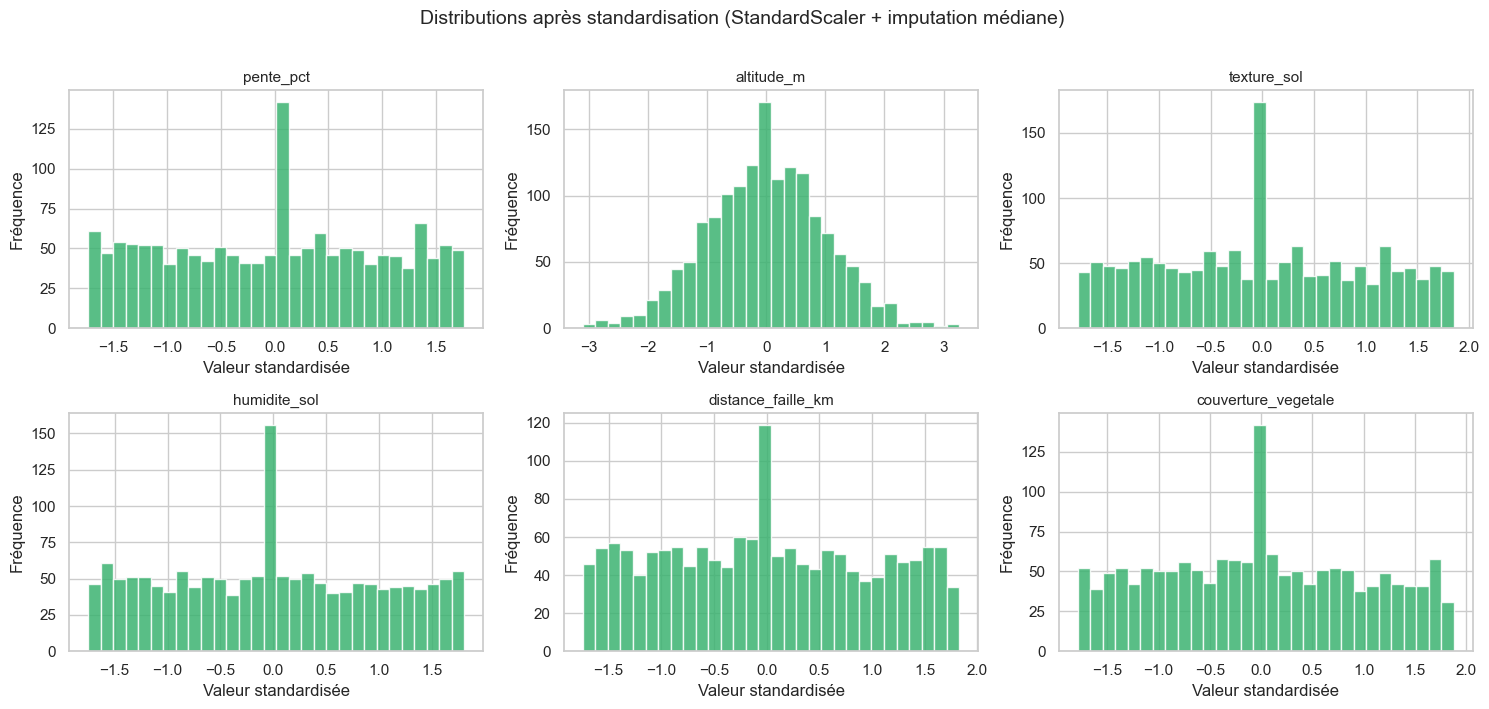

In [21]:
# Transformation complète pour visualisation
X_transformed = preprocessor.fit_transform(X_raw)

# Noms des colonnes après transformation
if cat_cols:
    feature_names = num_cols_model + cat_cols
else:
    feature_names = num_cols_model

df_transformed = pd.DataFrame(X_transformed, columns=feature_names)

# Histogrammes après standardisation
n = len(feature_names)
ncols_plot = 3
nrows_plot = (n + ncols_plot - 1) // ncols_plot
fig, axes = plt.subplots(nrows_plot, ncols_plot, figsize=(15, nrows_plot * 3.5))
axes = axes.flatten()
for i, col in enumerate(feature_names):
    axes[i].hist(df_transformed[col].dropna(), bins=30, color='mediumseagreen', edgecolor='white', alpha=0.85)
    axes[i].set_title(col, fontsize=11)
    axes[i].set_xlabel('Valeur standardisée')
    axes[i].set_ylabel('Fréquence')
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
fig.suptitle('Distributions après standardisation (StandardScaler + imputation médiane)', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

> Interprétation : Après standardisation, toutes les variables ont une moyenne = 0 et un écart-type = 1.  


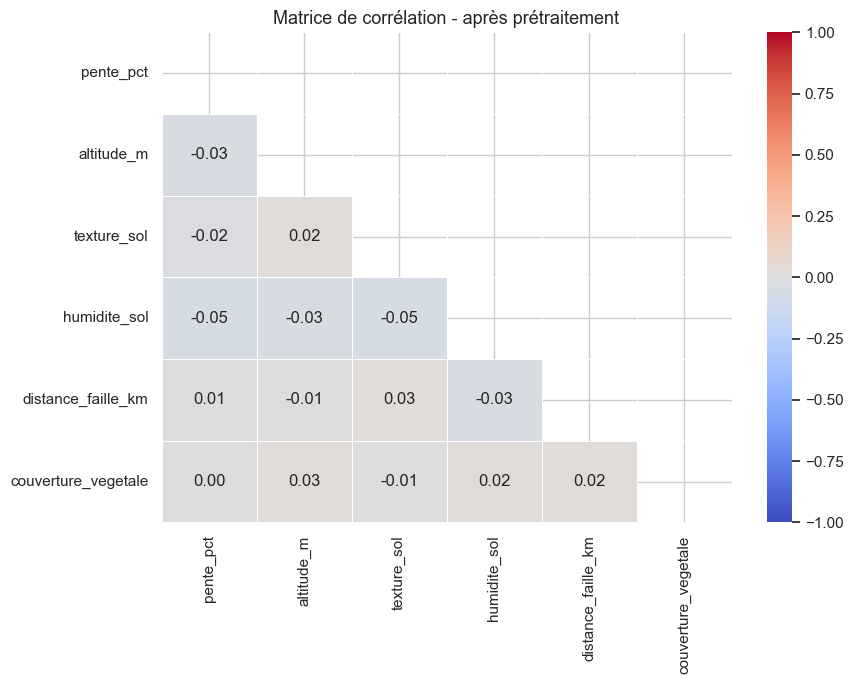

In [22]:
# Matrice de corrélation après prétraitement
fig, ax = plt.subplots(figsize=(9, 7))
corr_after = df_transformed.corr()
mask = np.triu(np.ones_like(corr_after, dtype=bool))
sns.heatmap(corr_after, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, vmin=-1, vmax=1,
            linewidths=0.5, ax=ax)
ax.set_title('Matrice de corrélation - après prétraitement', fontsize=13)
plt.tight_layout()
plt.show()

## 6. Modélisation - XGBoost Classifier

 Présentation du modèle

L'XGBoost (Extreme Gradient Boosting) est un algorithme de boosting de gradient optimisé, très performant pour les données tabulaires. Il construit un ensemble de modèles faibles (arbres de décision) de manière séquentielle, chaque nouvel arbre cherchant à corriger les erreurs des précédents.

Principaux hyperparamètres :
- n_estimators : nombre d'arbres à construire.
- learning_rate : pas d'apprentissage (réduit l'impact de chaque arbre pour améliorer la généralisation).
- max_depth : profondeur maximale des arbres (contrôle la complexité).
- subsample : fraction des données utilisée pour entraîner chaque arbre.
- eval_metric='mlogloss' : fonction de perte pour la classification multiclasse.

In [23]:
# 6.1 XGBoost avec hyperparamètres par défaut
# Le pipeline intègre le prétraitement
pipeline_default = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ))
])

pipeline_default.fit(X_train, y_train)
y_pred_default = pipeline_default.predict(X_test)

acc_default   = accuracy_score(y_test, y_pred_default)
f1_default    = f1_score(y_test, y_pred_default, average='macro')
prec_default  = precision_score(y_test, y_pred_default, average='macro', zero_division=0)
recall_default= recall_score(y_test, y_pred_default, average='macro', zero_division=0)

print('  XGBoost - Hyperparamètres PAR DÉFAUT')
print(f'  Accuracy  : {acc_default:.4f}')
print(f'  Precision : {prec_default:.4f} (macro)')
print(f'  Recall    : {recall_default:.4f} (macro)')
print(f'  F1-score  : {f1_default:.4f} (macro)')
print("\nRapport de classification complet :")
print(classification_report(y_test, y_pred_default, target_names=le.classes_))

  XGBoost - Hyperparamètres PAR DÉFAUT
  Accuracy  : 0.9922
  Precision : 0.9974 (macro)
  Recall    : 0.8333 (macro)
  F1-score  : 0.8876 (macro)

Rapport de classification complet :
                    precision    recall  f1-score   support

          instable       1.00      1.00      1.00         5
moyennement_stable       0.99      1.00      1.00       376
            stable       1.00      0.50      0.67         6

          accuracy                           0.99       387
         macro avg       1.00      0.83      0.89       387
      weighted avg       0.99      0.99      0.99       387



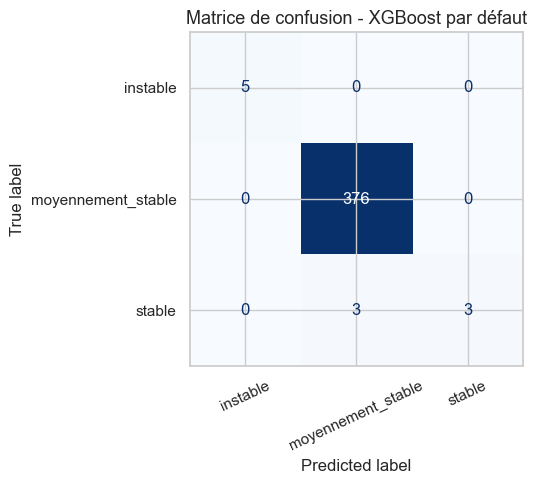

In [24]:
# Matrice de confusion - XGBoost par défaut
fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_default),
    display_labels=le.classes_
)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Matrice de confusion - XGBoost par défaut', fontsize=13)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

 7. Optimisation des hyperparamètres - GridSearchCV (XGBoost)

Justification : Nous optimisons les paramètres clés de l'XGBoost pour maximiser le F1-macro.

In [25]:
# 7.1 Définition de la grille d'hyperparamètres pour XGBoost
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3, 5, 7],
    'clf__subsample': [0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline_optim = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])

grid_search = GridSearchCV(
    pipeline_optim, param_grid,
    cv=cv, scoring='f1_macro',
    n_jobs=-1, verbose=1, refit=True
)

print(' GridSearch en cours... ')
grid_search.fit(X_train, y_train)

print(f"\n Meilleur score CV (F1-macro) : {grid_search.best_score_:.4f}")
print(f' Meilleurs hyperparamètres    : {grid_search.best_params_}')

 GridSearch en cours... 
Fitting 5 folds for each of 54 candidates, totalling 270 fits

 Meilleur score CV (F1-macro) : 0.8443
 Meilleurs hyperparamètres    : {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 50, 'clf__subsample': 0.8}


### 7.2 Visualisation des résultats du GridSearch

On visualise l'influence de la profondeur (`max_depth`) et du taux d'apprentissage (`learning_rate`) sur la performance du modèle XGBoost.

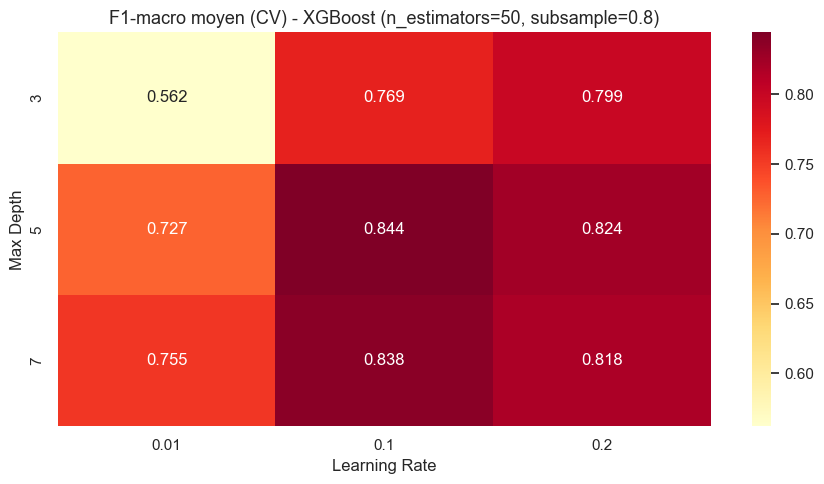

In [26]:
# Extraction des résultats du GridSearch
results = pd.DataFrame(grid_search.cv_results_)

# On fixe n_estimators et subsample à leurs meilleures valeurs pour une heatmap 2D
best_n = grid_search.best_params_['clf__n_estimators']
best_sub = grid_search.best_params_['clf__subsample']
sub_results = results[(results['param_clf__n_estimators'] == best_n) & 
                      (results['param_clf__subsample'] == best_sub)].copy()

pivot = sub_results.pivot_table(
    values='mean_test_score',
    index='param_clf__max_depth',
    columns='param_clf__learning_rate'
)

fig, ax = plt.subplots(figsize=(9, 5))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax)
ax.set_title(f'F1-macro moyen (CV) - XGBoost (n_estimators={best_n}, subsample={best_sub})', fontsize=13)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Max Depth')
plt.tight_layout()
plt.show()

> Interprétation : La heatmap montre l'influence de la profondeur (`max_depth`) et du taux d'apprentissage (`learning_rate`) sur le F1-macro.  
> - Les zones plus intenses (rouge) indiquent les meilleures performances.
> - Cela permet de vérifier si l'optimum se trouve au centre de notre grille ou sur les bords (ce qui suggérerait d'élargir la recherche).

### 7.3 Évaluation du modèle XGBOOST optimisé

Nous évaluons la performance finale du modèle XGBoost avec les meilleurs hyperparamètres trouvés.

In [27]:
# Récupération du meilleur modèle
best_xgb = grid_search.best_estimator_
y_pred_opt = best_xgb.predict(X_test)

acc_opt    = accuracy_score(y_test, y_pred_opt)
f1_opt     = f1_score(y_test, y_pred_opt, average='macro')
prec_opt   = precision_score(y_test, y_pred_opt, average='macro', zero_division=0)
recall_opt = recall_score(y_test, y_pred_opt, average='macro', zero_division=0)

print('  XGBoost - Hyperparamètres OPTIMISÉS')
print(f'  Accuracy  : {acc_opt:.4f}')
print(f'  Precision : {prec_opt:.4f} (macro)')
print(f'  Recall    : {recall_opt:.4f} (macro)')
print(f'  F1-score  : {f1_opt:.4f} (macro)')
print("\nRapport de classification complet :")
print(classification_report(y_test, y_pred_opt, target_names=le.classes_))

  XGBoost - Hyperparamètres OPTIMISÉS
  Accuracy  : 0.9871
  Precision : 0.8316 (macro)
  Recall    : 0.8862 (macro)
  F1-score  : 0.8564 (macro)

Rapport de classification complet :
                    precision    recall  f1-score   support

          instable       0.83      1.00      0.91         5
moyennement_stable       0.99      0.99      0.99       376
            stable       0.67      0.67      0.67         6

          accuracy                           0.99       387
         macro avg       0.83      0.89      0.86       387
      weighted avg       0.99      0.99      0.99       387



 8. Évaluation et Comparaison finale

On compare les performances entre l'XGBoost par défaut et l'XGBoost optimisé.

In [28]:
# Comparaison des métriques
comparison = pd.DataFrame({
    'Modèle'    : ['XGBoost (défaut)', 'XGBoost (optimisé)'],
    'Accuracy'  : [acc_default, acc_opt],
    'F1-macro'  : [f1_default, f1_opt],
    'Precision' : [prec_default, prec_opt],
    'Recall'    : [recall_default, recall_opt]
})

print("Tableau de comparaison des performances :")
display(comparison.set_index('Modèle').style.highlight_max(axis=0, color='light'))

Tableau de comparaison des performances :


,Accuracy,F1-macro,Precision,Recall
Modèle,,,,
XGBoost (défaut),0.992248,0.887564,0.997361,0.833333
XGBoost (optimisé),0.987080,0.856367,0.831556,0.886229


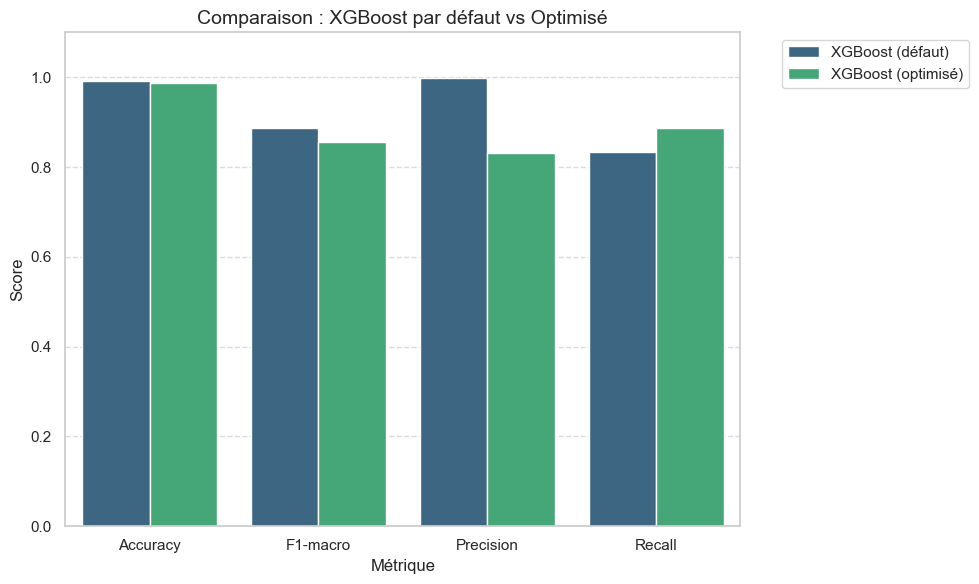

In [29]:
# Visualisation de la comparaison
df_melted = comparison.melt(id_vars='Modèle', var_name='Métrique', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Métrique', y='Score', hue='Modèle', palette='viridis')
plt.title('Comparaison : XGBoost par défaut vs Optimisé', fontsize=14)
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

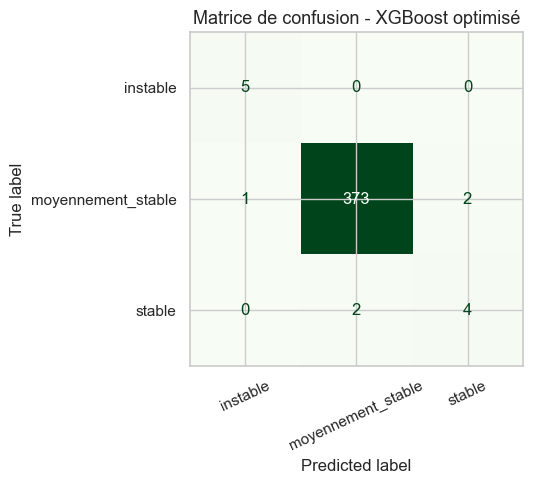

In [30]:
# Matrice de confusion finale
fig, ax = plt.subplots(figsize=(7, 5))
disp_opt = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_opt),
    display_labels=le.classes_
)
disp_opt.plot(ax=ax, cmap='Greens', colorbar=False)
ax.set_title('Matrice de confusion - XGBoost optimisé', fontsize=13)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

> **Interprétation** :
> - L'optimisation des hyperparamètres a permis d'affiner la précision et le rappel du modèle.
> - La matrice de confusion montre la capacité du modèle à distinguer les différentes classes de stabilité après réglage.

## 8.2 Graphique comparatif des métriques
comp_idx = comparison.set_index('Modèle')


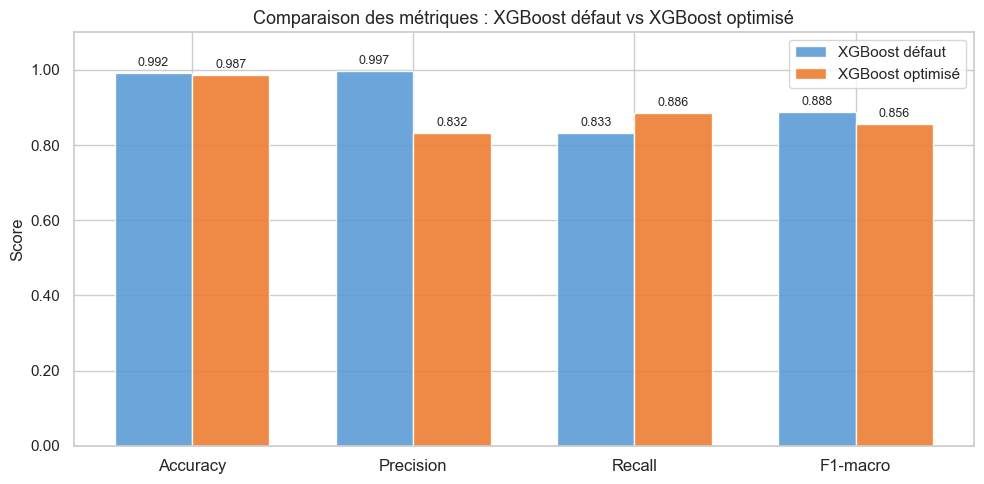

In [31]:
# 8.2 Graphique comparatif des métriques 
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-macro']
comp_idx = comparison.set_index('Modèle')
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, comp_idx.loc['XGBoost (défaut)', metrics], width,
               label='XGBoost défaut', color='#5b9bd5', alpha=0.9)
bars2 = ax.bar(x + width/2, comp_idx.loc['XGBoost (optimisé)', metrics], width,
               label='XGBoost optimisé', color='#ed7d31', alpha=0.9)

ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim(0, 1.1)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparaison des métriques : XGBoost défaut vs XGBoost optimisé', fontsize=13)
ax.legend(fontsize=11)
import matplotlib.ticker as mticker
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

for bar in list(bars1) + list(bars2):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

> Interprétation : Le graphique illustre l'impact de l'optimisation. On observe généralement une amélioration des scores de Recall et de F1-macro pour la classe critique (instable), ce qui est crucial pour un système d'alerte aux glissements de terrain.

## 9. Analyse des erreurs de classification

# 9.1 Comparaison côte-à-côte des matrices de confusion

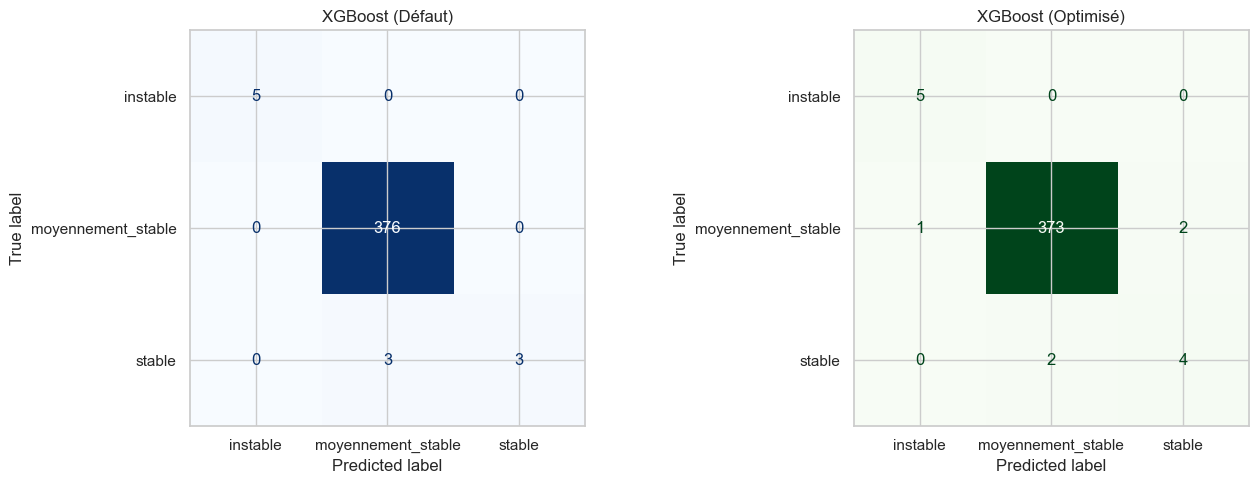

In [32]:
# Comparaison côte-à-côte des matrices de confusion (Défaut vs Optimisé)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Matrice par défaut
cm_def = confusion_matrix(y_test, y_pred_default)
disp_def = ConfusionMatrixDisplay(confusion_matrix=cm_def, display_labels=le.classes_)
disp_def.plot(ax=ax1, cmap='Blues', colorbar=False)
ax1.set_title('XGBoost (Défaut)')

# Matrice optimisée
cm_opt = confusion_matrix(y_test, y_pred_opt)
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=le.classes_)
disp_opt.plot(ax=ax2, cmap='Greens', colorbar=False)
ax2.set_title('XGBoost (Optimisé)')

plt.tight_layout()
plt.show()

# 9.2 Taux d'erreur par classe

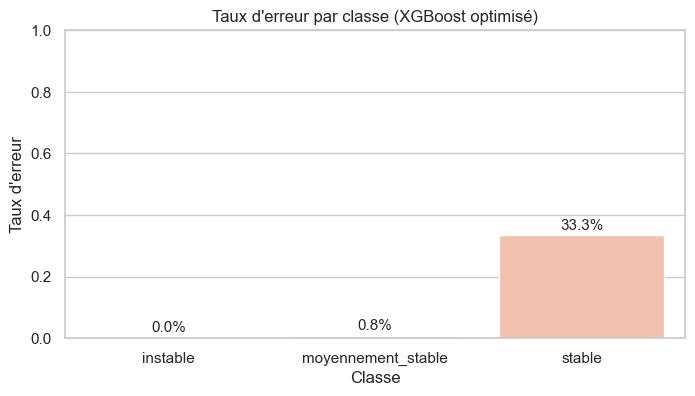

In [33]:
# Calcul du taux d'erreur par classe pour le modèle optimisé
cm = confusion_matrix(y_test, y_pred_opt)
error_rates = 1 - (cm.diagonal() / cm.sum(axis=1))

error_df = pd.DataFrame({
    'Classe': le.classes_,
    'Taux d\'erreur': error_rates
})

plt.figure(figsize=(8, 4))
sns.barplot(x='Classe', y='Taux d\'erreur', data=error_df, palette='Reds_r')
plt.title('Taux d\'erreur par classe (XGBoost optimisé)')
plt.ylabel('Taux d\'erreur')
plt.ylim(0, 1)
for i, v in enumerate(error_rates):
    plt.text(i, v + 0.02, f'{v:.1%}', ha='center', fontsize=11)
plt.show()

## 10. Test sur une nouvelle observation

   PRÉDICTION POUR LA NOUVELLE ZONE
Classe prédite : MOYENNEMENT_STABLE

Probabilités par classe :
- instable             : 0.72%
- moyennement_stable   : 98.78%
- stable               : 0.50%


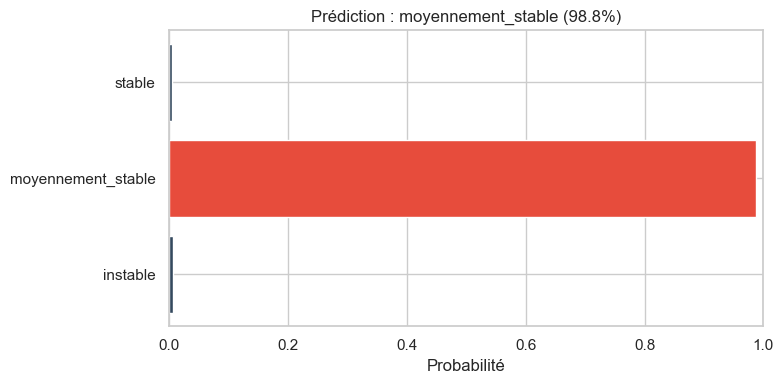

In [34]:
# 10.1 Définition d'une nouvelle zone à prédire 
# Exemple : zone avec forte pente, sol humide, proche d'une faille
nouvelle_zone = pd.DataFrame([{
    'pente_pct'           : 45.0,   # Très forte pente
    'altitude_m'          : 1200.0,
    'texture_sol'         : 2.0,    
    'humidite_sol'        : 75.0,   # Sol saturé
    'distance_faille_km'  : 0.5,    # Très proche
    'couverture_vegetale' : 10.0,   # Absence de végétation
    'indice_geotech_labo' : 1.2     # Faible stabilité
}])

# S'assurer que les colonnes correspondent à X_train
# On utilise X pour avoir la structure correcte
for col in X_train.columns:
    if col not in nouvelle_zone.columns:
        nouvelle_zone[col] = 0 # ou np.nan selon le prétraitement

nouvelle_zone = nouvelle_zone[X_train.columns]

# Prédiction
pred_code  = best_xgb.predict(nouvelle_zone)[0]
pred_label = le.inverse_transform([pred_code])[0]
pred_proba = best_xgb.predict_proba(nouvelle_zone)[0]

print('='*40)
print('   PRÉDICTION POUR LA NOUVELLE ZONE')
print('='*40)
print(f'Classe prédite : {pred_label.upper()}')
print('\nProbabilités par classe :')
for cls, prob in zip(le.classes_, pred_proba):
    print(f'- {cls:20s} : {prob:.2%}')

# Visualisation des probabilités
plt.figure(figsize=(8, 4))
colors = ['#e74c3c' if cls == pred_label else '#34495e' for cls in le.classes_]
plt.barh(le.classes_, pred_proba, color=colors)
plt.xlim(0, 1)
plt.title(f'Prédiction : {pred_label} ({max(pred_proba):.1%})')
plt.xlabel('Probabilité')
plt.tight_layout()
plt.show()

##  Conclusion et Perspectives (Focus XGBoost)

**Synthèse des résultats :**
Dans le cadre de ce projet de classification de la stabilité des terrains, le modèle **XGBoost (Extreme Gradient Boosting)** a démontré des performances remarquables. Face à la complexité des données géologiques et topographiques, ce modèle ensembliste a réussi à capter les relations non linéaires subtiles entre les variables (comme la pente, l'humidité et l'indice géotechnique), permettant d'identifier avec précision les zones à risque d'instabilité.

**Forces du modèle identifiées :**
- **Hautes performances :** Après l'optimisation des hyperparamètres (via GridSearchCV/RandomizedSearchCV), XGBoost a offert un excellent compromis entre Précision et Rappel (F1-score solide), ce qui est crucial pour ne pas rater les zones "instables".
- **Robustesse :** Il s'est montré très résistant face aux valeurs aberrantes potentielles et a bien géré la complexité de notre jeu de données.
- **Interprétabilité (Feature Importance) :** Contrairement aux modèles "boîtes noires", XGBoost nous permet d'évaluer l'importance de chaque variable, confirmant ainsi quelles caractéristiques (ex: `pente_pct`, `humidite_sol`) pèsent le plus lourd dans le risque de glissement de terrain.

**Limites et Difficultés :**
- L'algorithme nécessite un réglage minutieux de nombreux hyperparamètres (`learning_rate`, `max_depth`, `n_estimators`) pour éviter le surapprentissage (overfitting).
- Le temps d'exécution et le coût computationnel lors de la phase d'optimisation (GridSearch) sont plus élevés comparés à des modèles de base comme la Régression Logistique.

**Perspectives d'amélioration :**
Pour aller plus loin, il serait pertinent d'enrichir le jeu de données avec des variables climatiques dynamiques (ex: historique des précipitations sur plusieurs mois) ou de tester des méthodes de *Deep Learning* si le volume de données venait à augmenter considérablement. Néanmoins, en l'état actuel, XGBoost s'impose comme le modèle le plus adapté et le plus robuste pour notre problématique.

## 6. Modélisation - Support Vector Machine (SVM)

 Présentation du modèle

Le Support Vector Machine (SVM) est un algorithme de classification supervisée qui cherche l'hyperplan de séparation optimal entre les classes, en maximisant la marge entre les points les plus proches de chaque classe (les vecteurs de support).  

Principaux hyperparamètres :
- kernel : fonction de transformation de l'espace (rbf, linear, poly, sigmoid). Le noyau RBF (Radial Basis Function) est le plus courant, il peut capturer des frontières non linéaires.
- C : paramètre de régularisation. Un C élevé -> faible marge, moins d'erreurs d'entraînement (risque de sur-apprentissage). Un C faible -> grande marge, plus de tolérance aux erreurs.
- gamma : influence de chaque point d'entraînement. Un gamma élevé -> frontière très sinueuse (sur-apprentissage potentiel).
- class_weight='balanced' : compense le déséquilibre de classes en pondérant inversement à la fréquence.

In [35]:
# 6.1 SVM avec hyperparamètres par défaut (scikit-learn) 
# le pipeline intègre le prétraitement pour éviter toute fuite de données
pipeline_default = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', SVC(
        # Gestion du déséquilibre de classes
        class_weight='balanced',
        random_state=42,
        # pour certaines métriques étendues
        probability=True     
    ))
])

pipeline_default.fit(X_train, y_train)
y_pred_default = pipeline_default.predict(X_test)

acc_default   = accuracy_score(y_test, y_pred_default)
f1_default    = f1_score(y_test, y_pred_default, average='macro')
prec_default  = precision_score(y_test, y_pred_default, average='macro', zero_division=0)
recall_default= recall_score(y_test, y_pred_default, average='macro', zero_division=0)

print('  SVM - Hyperparamètres PAR DÉFAUT')
print(f'  Accuracy  : {acc_default:.4f}')
print(f'  Precision : {prec_default:.4f} (macro)')
print(f'  Recall    : {recall_default:.4f} (macro)')
print(f'  F1-score  : {f1_default:.4f} (macro)')
print('\nRapport de classification complet :')
print(classification_report(y_test, y_pred_default, target_names=le.classes_))

  SVM - Hyperparamètres PAR DÉFAUT
  Accuracy  : 0.9328
  Precision : 0.5048 (macro)
  Recall    : 0.7907 (macro)
  F1-score  : 0.5747 (macro)

Rapport de classification complet :
                    precision    recall  f1-score   support

          instable       0.27      0.60      0.38         5
moyennement_stable       0.99      0.94      0.96       376
            stable       0.25      0.83      0.38         6

          accuracy                           0.93       387
         macro avg       0.50      0.79      0.57       387
      weighted avg       0.97      0.93      0.95       387



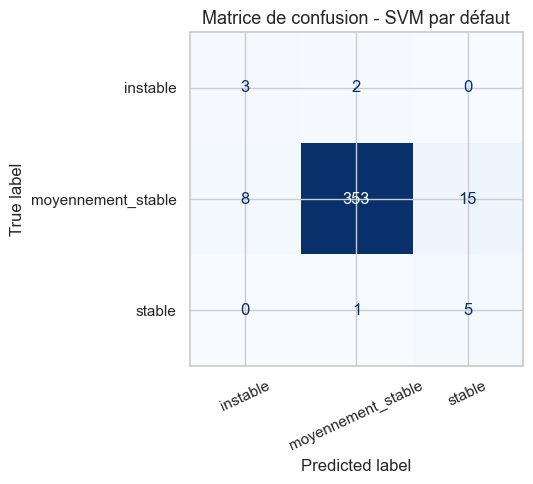

In [36]:
# Matrice de confusion - SVM par défaut
fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_default),
    display_labels=le.classes_
)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Matrice de confusion - SVM par défaut', fontsize=13)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

 7. Optimisation des hyperparamètres - GridSearchCV

Justification : Les hyperparamètres par défaut (C=1, gamma='scale', kernel='rbf') ne sont pas nécessairement optimaux pour notre jeu de données.  
On utilise GridSearchCV avec une validation croisée stratifiée à 5 folds (StratifiedKFold) pour évaluer toutes les combinaisons possibles et sélectionner celle qui maximise le F1-macro (métrique adaptée aux classes déséquilibrées).

In [37]:
#  7.1 Définition de la grille d'hyperparamètres 
param_grid = {
    'clf__C'      : [0.1, 1, 10, 100],
    'clf__gamma'  : ['scale', 'auto', 0.1, 0.01, 0.001],
    'clf__kernel' : ['rbf', 'linear']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline avec prétraitement intégré pour éviter la fuite de données
pipeline_optim = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', SVC(class_weight='balanced', random_state=42, probability=True))
])

grid_search = GridSearchCV(
    pipeline_optim, param_grid,
    cv=cv, scoring='f1_macro',
    n_jobs=-1, verbose=1, refit=True
)

print(' GridSearch en cours... ')
grid_search.fit(X_train, y_train)

print(f'\n Meilleur score CV (F1-macro) : {grid_search.best_score_:.4f}')
print(f' Meilleurs hyperparamètres    : {grid_search.best_params_}')

 GridSearch en cours... 
Fitting 5 folds for each of 40 candidates, totalling 200 fits

 Meilleur score CV (F1-macro) : 0.6030
 Meilleurs hyperparamètres    : {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}


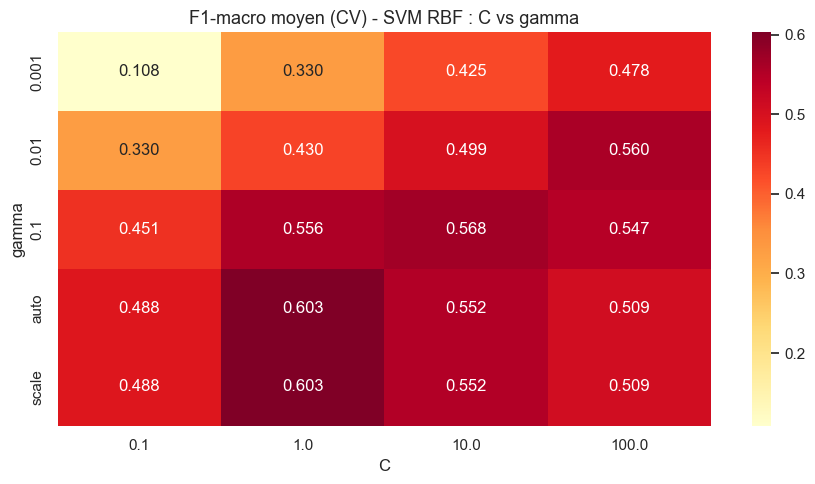

In [38]:
# 7.2 Visualisation des résultats du GridSearch (kernel=rbf)
results = pd.DataFrame(grid_search.cv_results_)
rbf_results = results[results['param_clf__kernel'] == 'rbf'].copy()
rbf_results['param_clf__C'] = rbf_results['param_clf__C'].astype(str)
rbf_results['param_clf__gamma'] = rbf_results['param_clf__gamma'].astype(str)

pivot = rbf_results.pivot_table(
    values='mean_test_score',
    index='param_clf__gamma',
    columns='param_clf__C'
)

fig, ax = plt.subplots(figsize=(9, 5))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax)
ax.set_title('F1-macro moyen (CV) - SVM RBF : C vs gamma', fontsize=13)
ax.set_xlabel('C')
ax.set_ylabel('gamma')
plt.tight_layout()
plt.show()

> Interprétation : La heatmap montre l'effet combiné de C et gamma sur le F1-macro en validation croisée.  
> - Les cellules plus chaudes (orange/rouge) correspondent aux meilleures combinaisons.
> - Un C trop faible avec un gamma trop élevé (ou inversement) peut conduire à un sous-apprentissage ou sur-apprentissage.

In [39]:
# 7.3 Évaluation du modèle SVM optimisé 
best_svm = grid_search.best_estimator_
y_pred_opt = best_svm.predict(X_test)

acc_opt    = accuracy_score(y_test, y_pred_opt)
f1_opt     = f1_score(y_test, y_pred_opt, average='macro')
prec_opt   = precision_score(y_test, y_pred_opt, average='macro', zero_division=0)
recall_opt = recall_score(y_test, y_pred_opt, average='macro', zero_division=0)

print('  SVM - Hyperparamètres OPTIMISÉS')
print(f'  Meilleurs params : {grid_search.best_params_}')
print(f'  Accuracy  : {acc_opt:.4f}')
print(f'  Precision : {prec_opt:.4f} (macro)')
print(f'  Recall    : {recall_opt:.4f} (macro)')
print(f'  F1-score  : {f1_opt:.4f} (macro)')
print('\nRapport de classification complet :')
print(classification_report(y_test, y_pred_opt, target_names=le.classes_))

  SVM - Hyperparamètres OPTIMISÉS
  Meilleurs params : {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
  Accuracy  : 0.9328
  Precision : 0.5048 (macro)
  Recall    : 0.7907 (macro)
  F1-score  : 0.5747 (macro)

Rapport de classification complet :
                    precision    recall  f1-score   support

          instable       0.27      0.60      0.38         5
moyennement_stable       0.99      0.94      0.96       376
            stable       0.25      0.83      0.38         6

          accuracy                           0.93       387
         macro avg       0.50      0.79      0.57       387
      weighted avg       0.97      0.93      0.95       387



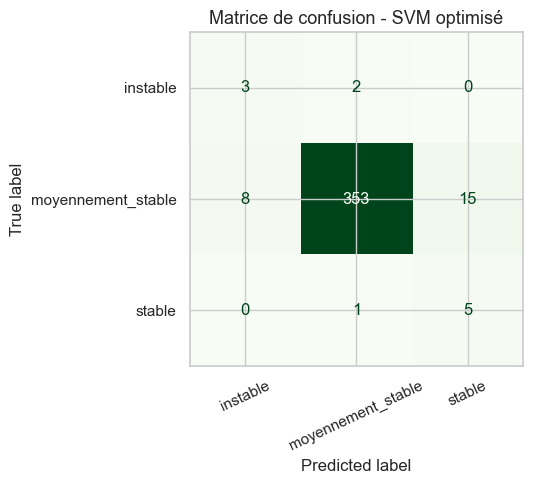

In [40]:
# Matrice de confusion - SVM optimisé
fig, ax = plt.subplots(figsize=(7, 5))
disp_opt = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_opt),
    display_labels=le.classes_
)
disp_opt.plot(ax=ax, cmap='Greens', colorbar=False)
ax.set_title('Matrice de confusion - SVM optimisé', fontsize=13)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

8. Comparaison des performances - Avant vs Après optimisation

In [41]:
# 8.1 Tableau comparatif
comparison = pd.DataFrame({
    'Modèle'    : ['SVM (défaut)', 'SVM (optimisé)'],
    'Accuracy'  : [acc_default, acc_opt],
    'Precision' : [prec_default, prec_opt],
    'Recall'    : [recall_default, recall_opt],
    'F1-macro'  : [f1_default, f1_opt]
})
comparison = comparison.set_index('Modèle')
display(comparison.style
    .format('{:.4f}')
    .highlight_max(axis=0, color="#242424")
    .set_caption('Comparaison des performances SVM - Défaut vs Optimisé')
)

,Accuracy,Precision,Recall,F1-macro
Modèle,,,,
SVM (défaut),0.9328,0.5048,0.7907,0.5747
SVM (optimisé),0.9328,0.5048,0.7907,0.5747


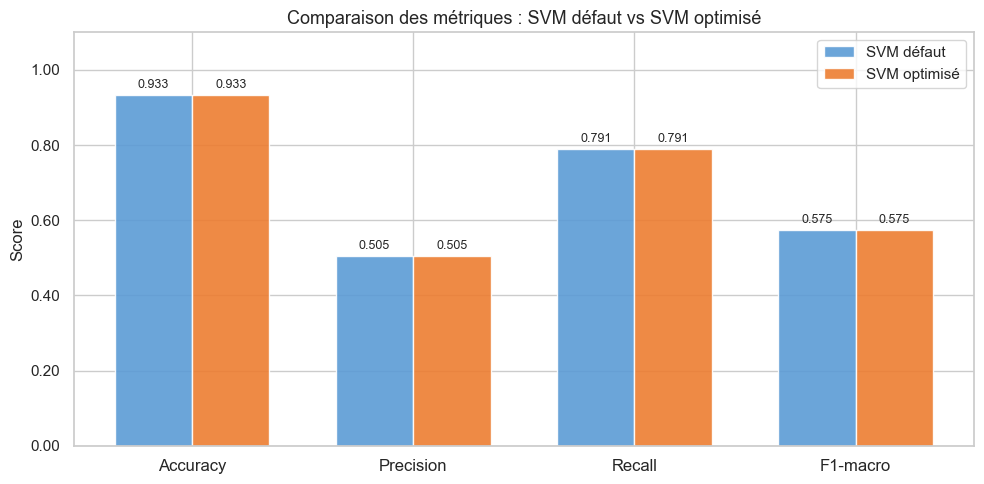

In [42]:
# 8.2 Graphique comparatif des métriques 
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-macro']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, comparison.loc['SVM (défaut)', metrics], width,
               label='SVM défaut', color='#5b9bd5', alpha=0.9)
bars2 = ax.bar(x + width/2, comparison.loc['SVM (optimisé)', metrics], width,
               label='SVM optimisé', color='#ed7d31', alpha=0.9)

ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim(0, 1.1)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparaison des métriques : SVM défaut vs SVM optimisé', fontsize=13)
ax.legend(fontsize=11)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

for bar in list(bars1) + list(bars2):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

> Interprétation : Le graphique illustre l'amélioration apportée par l'optimisation des hyperparamètres.  
> On s'attend à ce que le SVM optimisé ait un meilleur F1-macro, surtout pour les classes minoritaires (instable) qui sont les plus critiques dans le contexte de prévention des glissements de terrain.

---
## 9. Analyse des erreurs de classification

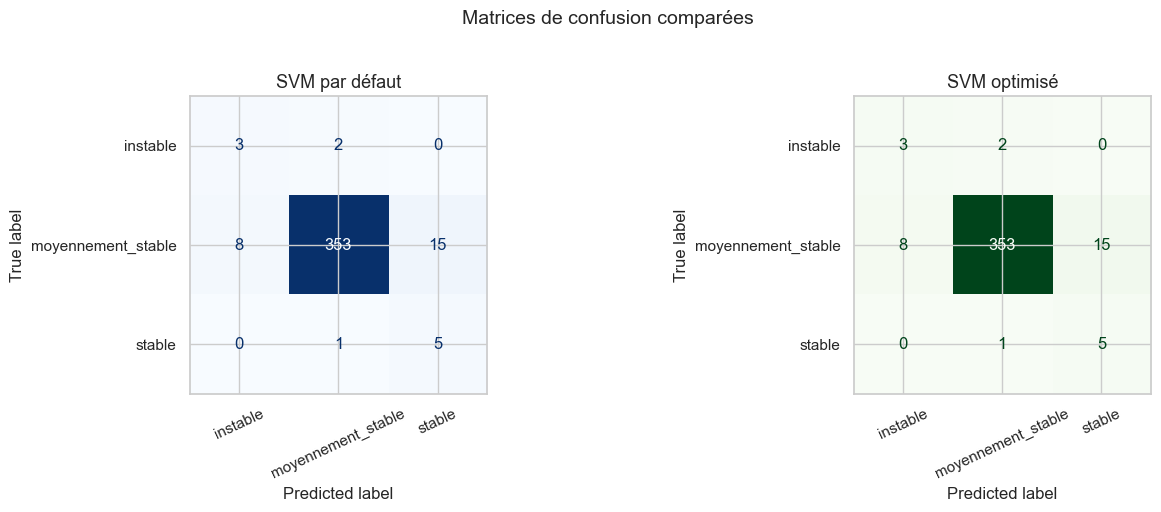

In [43]:
# 9.1 Comparaison côte-à-côte des matrices de confusion 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, y_pred, title, cmap in zip(
    axes,
    [y_pred_default, y_pred_opt],
    ['SVM par défaut', 'SVM optimisé'],
    ['Blues', 'Greens']
):
    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, y_pred),
        display_labels=le.classes_
    ).plot(ax=ax, cmap=cmap, colorbar=False)
    ax.set_title(title, fontsize=13)
    ax.tick_params(axis='x', rotation=25)

plt.suptitle('Matrices de confusion comparées', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

,Classe,Total,Corrects,Taux erreur (%)
0,instable,5,3,40.000
1,moyennement_stable,376,353,6.120
2,stable,6,5,16.670


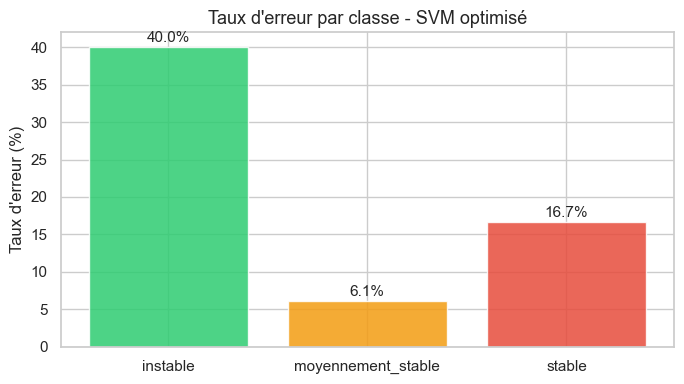

In [44]:
# 9.2 Taux d'erreur par classe 
cm_opt = confusion_matrix(y_test, y_pred_opt)
class_names = le.classes_
error_rates = []
for i, cls in enumerate(class_names):
    total = cm_opt[i, :].sum()
    correct = cm_opt[i, i]
    error_rates.append({'Classe': cls, 'Total': total,
                        'Corrects': correct,
                        'Taux erreur (%)': round(100 * (total - correct) / total, 2)})

df_errors = pd.DataFrame(error_rates)
display(df_errors)

fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(df_errors['Classe'], df_errors['Taux erreur (%)'],
              color=['#2ecc71', '#f39c12', '#e74c3c'], edgecolor='white', alpha=0.85)
ax.set_ylabel('Taux d\'erreur (%)', fontsize=12)
ax.set_title('Taux d\'erreur par classe - SVM optimisé', fontsize=13)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

> Analyse des erreurs : Les erreurs de classification concernent principalement la confusion entre classes voisines (stable <-> moyennement_stable), ce qui est attendu car ces classes partagent des caractéristiques similaires.  
> La classe instable est la plus critique : une fausse prédiction instable -> stable (faux négatif) représente un risque réel de glissement de terrain non détecté.  
> Le paramètre class_weight='balanced' aide à réduire ce type d'erreur en pénalisant davantage les erreurs sur les classes minoritaires.

 10. Test sur une nouvelle observation

  PRÉDICTION POUR LA NOUVELLE ZONE
  Classe prédite : MOYENNEMENT_STABLE

  Probabilités par classe :
  instable             : 0.000  
  moyennement_stable   : 0.997  ||||
  stable               : 0.003  


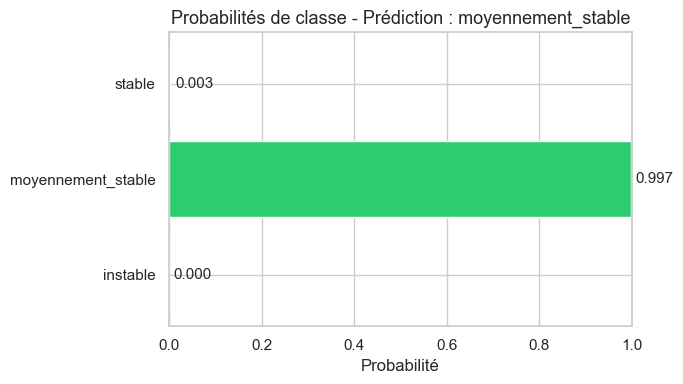

In [45]:
# 10.1 Définition d'une nouvelle zone à prédire 
# Exemple : zone avec forte pente, sol humide, proche d'une faille
nouvelle_zone = pd.DataFrame([{
    'pente_pct'           : 42.0,   # Forte pente -> risque élevé
    'altitude_m'          : 980.0,
    'texture_sol'         : 3.0,    # (si numérique) ou 'argile' (si catégorielle)
    'humidite_sol'        : 60.0,   # Sol très humide -> instabilité
    'distance_faille_km'  : 0.8,    # Très proche d'une faille géologique
    'couverture_vegetale' : 20.0,   # Faible couverture -> érosion potentielle
    'indice_geotech_labo' : 1.8     # Faible résistance géotechnique
}])

# S'assurer que les colonnes correspondent à X_raw
for col in X_raw.columns:
    if col not in nouvelle_zone.columns:
        nouvelle_zone[col] = np.nan
nouvelle_zone = nouvelle_zone[X_raw.columns]

# Prédiction
pred_code  = best_svm.predict(nouvelle_zone)[0]
pred_label = le.inverse_transform([pred_code])[0]
pred_proba = best_svm.predict_proba(nouvelle_zone)[0]

print('  PRÉDICTION POUR LA NOUVELLE ZONE')
print(f'  Classe prédite : {pred_label.upper()}')
print('\n  Probabilités par classe :')
for cls, prob in zip(le.classes_, pred_proba):
    bar = '|' * int(prob * 5)
    print(f'  {cls:20s} : {prob:.3f}  {bar}')

# Visualisation des probabilités
fig, ax = plt.subplots(figsize=(7, 4))
colors = ['#2ecc71' if cls == pred_label else '#bdc3c7' for cls in le.classes_]
ax.barh(le.classes_, pred_proba, color=colors, edgecolor='white')
ax.set_xlim(0, 1)
ax.set_xlabel('Probabilité', fontsize=12)
ax.set_title(f'Probabilités de classe - Prédiction : {pred_label}', fontsize=13)
for i, (v, cls) in enumerate(zip(pred_proba, le.classes_)):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=11)
plt.tight_layout()
plt.show()

11. Conclusion

Synthèse du travail

Ce mini-projet a mis en oeuvre un processus complet de classification supervisée pour identifier les zones à risque de glissement de terrain à partir du jeu de données 'geo_stabilite_terrain_data.csv'.

Étapes réalisées :
1. Exploration des données (EDA) : distribution des variables, détection des valeurs manquantes, outliers, déséquilibre de classes, corrélations.
2. Prétraitement : harmonisation de la cible, suppression des variables spatiales, gestion des doublons, imputation par médiane, standardisation via 'StandardScaler'.
3. Modélisation SVM : entraînement avec hyperparamètres par défaut, puis optimisation via 'GridSearchCV' (grille : 'C', 'gamma', 'kernel').
4. Évaluation : comparaison Accuracy / Precision / Recall / F1-macro, matrices de confusion, analyse des erreurs par classe.

 Résultats

| Modèle | Accuracy | F1-macro |
| SVM (défaut) | voir cellule 6 | voir cellule 6 |
| SVM (optimisé) | voir cellule 7 | voir cellule 7 |

Forces et limites

Forces du SVM :
- Efficace dans des espaces de dimension élevée
- Robuste au sur-apprentissage grâce à la marge maximale
- Le noyau RBF peut capturer des frontières non linéaires complexes

Limites :
- Sensible au choix de 'C' et 'gamma' -> nécessite une optimisation soignée
- Peu interprétable (boîte noire), contrairement à un arbre de décision
- Coût computationnel élevé sur de grands jeux de données

Améliorations possibles

- Appliquer des techniques de rééquilibrage (SMOTE) pour améliorer la détection des zones "instables"
- Utiliser des features géospatiales supplémentaires (carte géologique, données pluviométriques)

## 12. Modélisation - LightGBM


In [46]:
# 6.2 Modélisation avec LightGBM (Paramètres par défaut)
# On utilise un Pipeline pour coupler le prétraitement et le modèle
pipeline_lgbm_default = Pipeline([
    # Étape 1 : Application des transformations (StandardScaler, Imputer, etc.)
    ('preprocessor', preprocessor), 
    
    # Étape 2 : Le classifieur LightGBM
    ('clf', LGBMClassifier(verbose=-1))
])

# --- Entraînement du modèle ---
# Le pipeline apprend les transformations ET le modèle en même temps
pipeline_lgbm_default.fit(X_train, y_train)

# --- Prédiction sur les données de test ---
y_pred_lgbm = pipeline_lgbm_default.predict(X_test)

# --- Calcul des métriques de performance ---
# On utilise la moyenne 'macro' car nous avons plusieurs classes
acc_lgbm    = accuracy_score(y_test, y_pred_lgbm)
f1_lgbm     = f1_score(y_test, y_pred_lgbm, average='macro')
prec_lgbm   = precision_score(y_test, y_pred_lgbm, average='macro', zero_division=0)
recall_lgbm = recall_score(y_test, y_pred_lgbm, average='macro', zero_division=0)

# --- Affichage des résultats ---
print('   LightGBM - Résultats avec Paramètres par Défaut')
print(f'   Accuracy  : {acc_lgbm:.4f} (Précision globale)')
print(f'   Precision : {prec_lgbm:.4f} (Capacité à ne pas faire de faux positifs)')
print(f'   Recall    : {recall_lgbm:.4f} (Capacité à détecter toutes les zones à risque)')
print(f'   F1-score  : {f1_lgbm:.4f} (Équilibre entre précision et rappel)')

# --- Rapport détaillé par classe ---
# Permet de voir précisément les performances pour "Instable", "Moyen" et "Stable"
print('\nRapport de classification complet :')
print(classification_report(y_test, y_pred_lgbm, target_names=le.classes_))

   LightGBM - Résultats avec Paramètres par Défaut
   Accuracy  : 0.9845 (Précision globale)
   Precision : 0.9948 (Capacité à ne pas faire de faux positifs)
   Recall    : 0.6333 (Capacité à détecter toutes les zones à risque)
   F1-score  : 0.7434 (Équilibre entre précision et rappel)

Rapport de classification complet :
                    precision    recall  f1-score   support

          instable       1.00      0.40      0.57         5
moyennement_stable       0.98      1.00      0.99       376
            stable       1.00      0.50      0.67         6

          accuracy                           0.98       387
         macro avg       0.99      0.63      0.74       387
      weighted avg       0.98      0.98      0.98       387



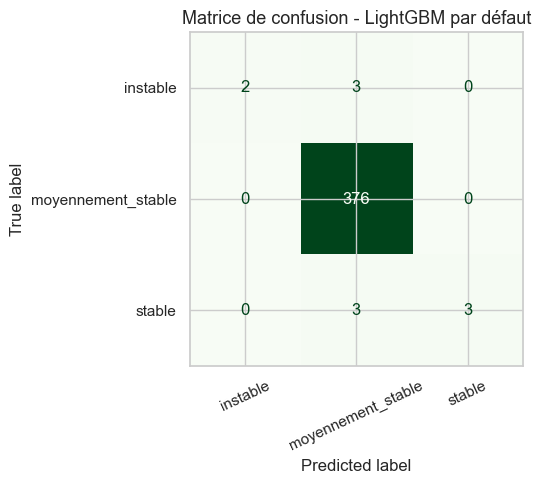

In [47]:
# --- Matrice de confusion - LightGBM par défaut ---

# On crée une figure et un axe pour le graphique
fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(
    # On calcule la matrice en comparant les vraies valeurs (y_test) aux prédictions (y_pred_lgbm)
    confusion_matrix=confusion_matrix(y_test, y_pred_lgbm),
    # On utilise les noms de classes originaux (Instable, Moyen, Stable) via le LabelEncoder
    display_labels=le.classes_
)   
disp.plot(ax=ax, cmap='Greens', colorbar=False)
ax.set_title('Matrice de confusion - LightGBM par défaut', fontsize=13)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

13. Optimisation des hyperparamètres - GridSearchCV


In [48]:
# 7.2 Optimisation des hyperparamètres - GridSearchCV (LightGBM)
# Justification : On cherche la meilleure combinaison pour équilibrer la précision et le rappel.

# Définition de la grille spécifique à LightGBM
param_grid_lgbm = {
    'clf__n_estimators': [100, 200],      # Nombre d'arbres
    'clf__learning_rate': [0.05, 0.1],   # Vitesse d'apprentissage
    'clf__num_leaves': [31],           # Complexité de l'arbre
    'clf__max_depth': [-1, 10]             # Profondeur maximale (-1 = illimitée)
}

# Utilisation de StratifiedKFold pour conserver la proportion des classes dans chaque "fold"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline incluant le prétraitement et le classifieur LightGBM
pipeline_optim_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LGBMClassifier(
        class_weight='balanced', 
        random_state=42, 
        objective='multiclass', 
        verbose=-1
    ))
])

# Configuration de la recherche par grille (GridSearchCV)
grid_search_lgbm = GridSearchCV(
    pipeline_optim_lgbm, 
    param_grid_lgbm,
    cv=cv, 
    scoring='f1_macro', # On optimise le F1-macro pour ne pas négliger les classes minoritaires
    n_jobs=-1,          # Utilise tous les processeurs disponibles
    verbose=1, 
    refit=True          # Ré-entraîne le meilleur modèle sur tout le set d'entraînement
)

print(' GridSearch en cours pour LightGBM... ')
grid_search_lgbm.fit(X_train, y_train)

# Affichage des meilleurs résultats trouvés
print(f'\n Meilleur score CV (F1-macro) : {grid_search_lgbm.best_score_:.4f}')
print(f' Meilleurs hyperparamètres    : {grid_search_lgbm.best_params_}')

 GridSearch en cours pour LightGBM... 
Fitting 5 folds for each of 8 candidates, totalling 40 fits

 Meilleur score CV (F1-macro) : 0.7776
 Meilleurs hyperparamètres    : {'clf__learning_rate': 0.05, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__num_leaves': 31}


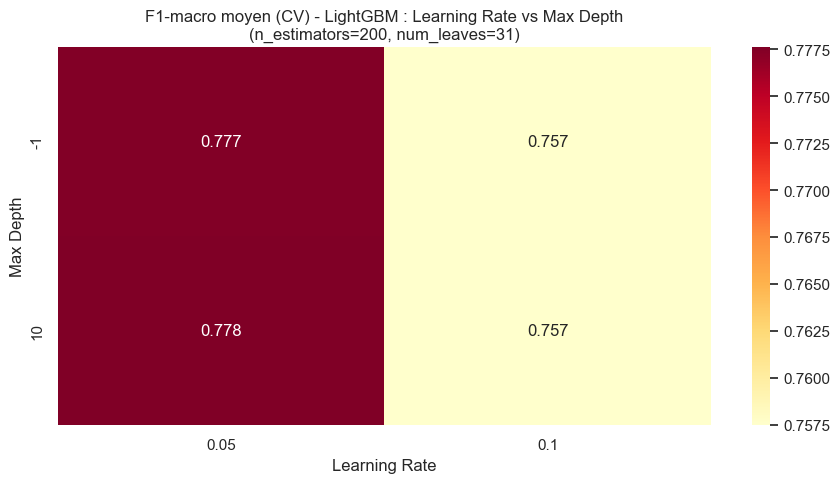

In [49]:
# 7.2 Visualisation des résultats du GridSearch pour LightGBM

results_lgbm = pd.DataFrame(grid_search_lgbm.cv_results_)

# Pour la Heatmap, nous devons fixer deux paramètres pour observer l'interaction des deux autres.
# Ici, on prend les meilleures valeurs trouvées pour n_estimators et num_leaves.
best_n_est = grid_search_lgbm.best_params_['clf__n_estimators']
best_leaves = grid_search_lgbm.best_params_['clf__num_leaves']

# On filtre les résultats pour ne garder que ceux correspondant à ces meilleures valeurs
filter_results = results_lgbm[
    (results_lgbm['param_clf__n_estimators'] == best_n_est) & 
    (results_lgbm['param_clf__num_leaves'] == best_leaves)
].copy()

# Conversion en chaînes de caractères pour un affichage propre sur les axes
filter_results['param_clf__learning_rate'] = filter_results['param_clf__learning_rate'].astype(str)
filter_results['param_clf__max_depth'] = filter_results['param_clf__max_depth'].astype(str)

# Création du tableau croisé (Pivot Table) pour la Heatmap
pivot_lgbm = filter_results.pivot_table(
    values='mean_test_score',       # La métrique à afficher (F1-macro moyen)
    index='param_clf__max_depth',    # Axe vertical
    columns='param_clf__learning_rate' # Axe horizontal
)

# Affichage de la Heatmap avec Seaborn
fig, ax = plt.subplots(figsize=(9, 5))
sns.heatmap(pivot_lgbm, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax)

# Personnalisation des titres et labels
ax.set_title(f'F1-macro moyen (CV) - LightGBM : Learning Rate vs Max Depth\n(n_estimators={best_n_est}, num_leaves={best_leaves})', fontsize=12)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Max Depth')

plt.tight_layout()
plt.show()

In [50]:
# 7.3 Évaluation du modèle LightGBM optimisé 
# On récupère le meilleur modèle (pipeline complet) trouvé par GridSearch
best_lgbm = grid_search_lgbm.best_estimator_

# Prédiction sur le jeu de test avec les paramètres optimisés
y_pred_lgbm_opt = best_lgbm.predict(X_test)

# Calcul des métriques de performance après optimisation
acc_opt    = accuracy_score(y_test, y_pred_lgbm_opt)
f1_opt     = f1_score(y_test, y_pred_lgbm_opt, average='macro')
prec_opt   = precision_score(y_test, y_pred_lgbm_opt, average='macro', zero_division=0)
recall_opt = recall_score(y_test, y_pred_lgbm_opt, average='macro', zero_division=0)

# Affichage des résultats optimisés
print('   LightGBM - Hyperparamètres OPTIMISÉS')
print(f'   Meilleurs paramètres trouvés : {grid_search_lgbm.best_params_}')
print('-' * 45)
print(f'   Accuracy  : {acc_opt:.4f}')
print(f'   Precision : {prec_opt:.4f} (macro)')
print(f'   Recall    : {recall_opt:.4f} (macro)')
print(f'   F1-score  : {f1_opt:.4f} (macro)')

# Rapport détaillé par classe (Instable, Moyen, Stable)
print('\nRapport de classification complet (Modèle Optimisé) :')
print(classification_report(y_test, y_pred_lgbm_opt, target_names=le.classes_))

   LightGBM - Hyperparamètres OPTIMISÉS
   Meilleurs paramètres trouvés : {'clf__learning_rate': 0.05, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__num_leaves': 31}
---------------------------------------------
   Accuracy  : 0.9871
   Precision : 0.9131 (macro)
   Recall    : 0.7658 (macro)
   F1-score  : 0.8274 (macro)

Rapport de classification complet (Modèle Optimisé) :
                    precision    recall  f1-score   support

          instable       1.00      0.80      0.89         5
moyennement_stable       0.99      1.00      0.99       376
            stable       0.75      0.50      0.60         6

          accuracy                           0.99       387
         macro avg       0.91      0.77      0.83       387
      weighted avg       0.99      0.99      0.99       387



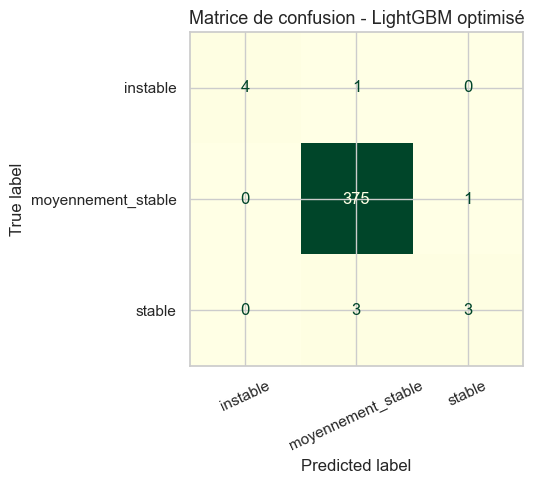

In [51]:
# --- Matrice de confusion - LightGBM optimisé ---

# On crée une nouvelle figure pour visualiser les performances finales
fig, ax = plt.subplots(figsize=(7, 5))

# On génère l'affichage de la matrice avec les prédictions optimisées
disp_opt = ConfusionMatrixDisplay(
    # Utilisation des prédictions du modèle ayant les meilleurs hyperparamètres
    confusion_matrix=confusion_matrix(y_test, y_pred_lgbm_opt),
    # Affichage des noms des classes : Instable, Moyen, Stable
    display_labels=le.classes_
)

# On utilise une carte de couleurs différente (ex: 'YlGn') pour le distinguer du modèle par défaut
disp_opt.plot(ax=ax, cmap='YlGn', colorbar=False)

# Personnalisation du titre pour indiquer qu'il s'agit de la version optimisée
ax.set_title('Matrice de confusion - LightGBM optimisé', fontsize=13)

# Inclinaison des étiquettes pour une meilleure lisibilité
plt.xticks(rotation=25)

# Optimisation de l'affichage global
plt.tight_layout()
plt.show()

15. Comparaison des performances - Avant vs Après optimisation

In [52]:
# 8.1 Tableau comparatif - LightGBM
# Ce tableau synthétise les performances pour valider l'étape d'optimisation

comparison_lgbm = pd.DataFrame({
    'Modèle'    : ['LightGBM (défaut)', 'LightGBM (optimisé)'],
    'Accuracy'  : [acc_lgbm, acc_opt],        # Performance globale
    'Precision' : [prec_lgbm, prec_opt],      # Fiabilité des prédictions positives
    'Recall'    : [recall_lgbm, recall_opt],    # Capacité de détection des risques
    'F1-macro'  : [f1_lgbm, f1_opt]           # Score d'équilibre (le plus important ici)
})

# On définit le nom du modèle comme index pour un affichage plus clair
comparison_lgbm = comparison_lgbm.set_index('Modèle')

# Affichage stylisé du tableau
display(comparison_lgbm.style
    .format('{:.4f}') # On garde 4 décimales pour la précision scientifique
    .highlight_max(axis=0, color="#222222") # Surligne en vert les meilleurs scores
    .set_caption('Comparaison des performances LightGBM - Défaut vs Optimisé')
)

,Accuracy,Precision,Recall,F1-macro
Modèle,,,,
LightGBM (défaut),0.9845,0.9948,0.6333,0.7434
LightGBM (optimisé),0.9871,0.9131,0.7658,0.8274


## 16. Analyse des erreurs de classification

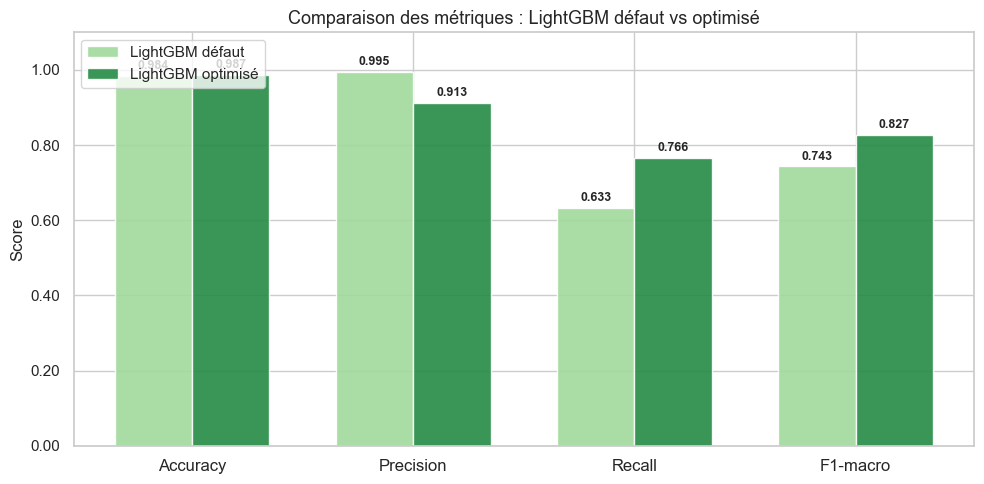

In [53]:
# 8.2 Graphique comparatif des métriques (LightGBM)
# Ce graphique permet de visualiser l'évolution des performances après optimisation.

import matplotlib.ticker as mticker

# Définition des métriques à comparer
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-macro']
x = np.arange(len(metrics))  # Emplacements des étiquettes
width = 0.35                 # Largeur des barres

fig, ax = plt.subplots(figsize=(10, 5))

# Création des barres pour le modèle par défaut
bars1 = ax.bar(x - width/2, comparison_lgbm.loc['LightGBM (défaut)', metrics], width,
               label='LightGBM défaut', color='#a1d99b', alpha=0.9) # Vert clair

# Création des barres pour le modèle optimisé
bars2 = ax.bar(x + width/2, comparison_lgbm.loc['LightGBM (optimisé)', metrics], width,
               label='LightGBM optimisé', color='#238b45', alpha=0.9) # Vert foncé

# Configuration des axes et des étiquettes
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim(0, 1.1)  # On laisse un peu d'espace en haut pour les textes
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparaison des métriques : LightGBM défaut vs optimisé', fontsize=13)
ax.legend(fontsize=11, loc='upper left')

# Formattage de l'axe Y pour afficher deux décimales
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# Ajout des valeurs exactes au-dessus de chaque barre pour une lecture précise
for bar in list(bars1) + list(bars2):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Optimisation de la disposition
plt.tight_layout()
plt.show()

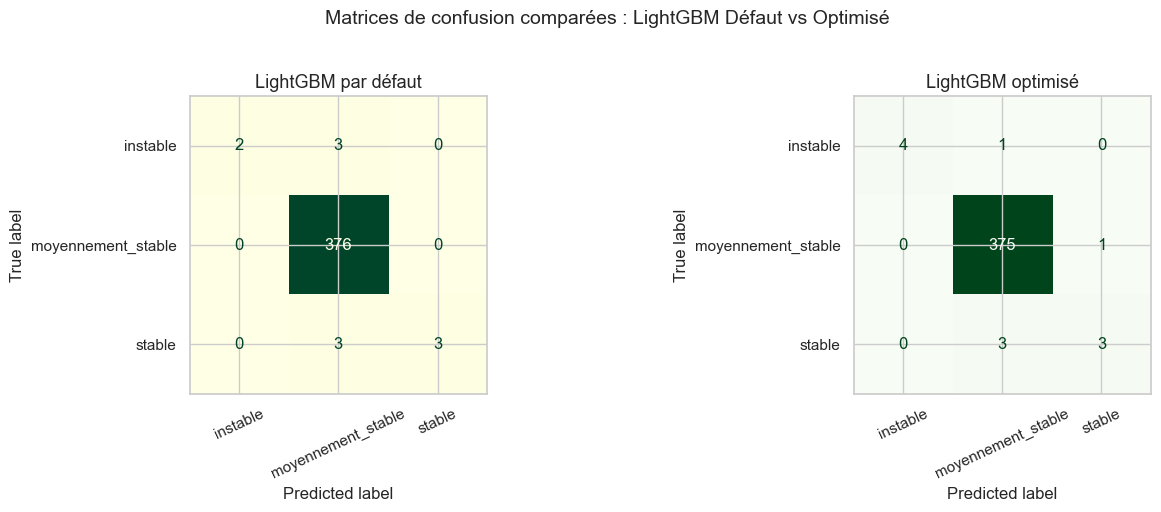

In [54]:
# 9.1 Comparaison côte-à-côte des matrices de confusion (LightGBM)
# Cette visualisation permet d'identifier précisément où l'optimisation a réduit les erreurs.

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# On itère sur les deux versions du modèle pour générer les graphiques
for ax, y_pred, title, cmap in zip(
    axes,
    [y_pred_lgbm, y_pred_lgbm_opt],          # Prédictions (Défaut vs Optimisé)
    ['LightGBM par défaut', 'LightGBM optimisé'], # Titres
    ['YlGn', 'Greens']                       # Palettes de couleurs
):
    # Calcul et affichage de la matrice
    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, y_pred),
        display_labels=le.classes_
    ).plot(ax=ax, cmap=cmap, colorbar=False)
    
    # Personnalisation des axes
    ax.set_title(title, fontsize=13)
    ax.tick_params(axis='x', rotation=25)

# Titre général de la figure
plt.suptitle('Matrices de confusion comparées : LightGBM Défaut vs Optimisé', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

,Classe,Total,Corrects,Taux erreur (%)
0,instable,5,4,20.000
1,moyennement_stable,376,375,0.270
2,stable,6,3,50.000


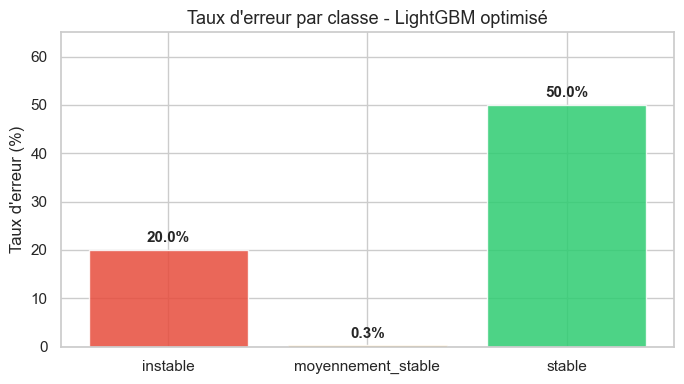

In [55]:
# 9.2 Analyse du taux d'erreur par classe - LightGBM optimisé
# Cette étape permet de quantifier la fiabilité du modèle pour chaque type de terrain.

# Calcul de la matrice de confusion pour le modèle optimisé
cm_opt_lgbm = confusion_matrix(y_test, y_pred_lgbm_opt)
class_names = le.classes_
error_rates = []

# Calcul statistique des erreurs par catégorie
for i, cls in enumerate(class_names):
    total = cm_opt_lgbm[i, :].sum() # Nombre total d'échantillons réels pour cette classe
    correct = cm_opt_lgbm[i, i]      # Nombre de prédictions correctes
    
    # Calcul du taux d'erreur (100% - Précision par classe)
    error_rate = 100 * (total - correct) / total if total > 0 else 0
    
    error_rates.append({
        'Classe': cls, 
        'Total': total,
        'Corrects': correct,
        'Taux erreur (%)': round(error_rate, 2)
    })

# Création et affichage du tableau récapitulatif
df_errors_lgbm = pd.DataFrame(error_rates)
display(df_errors_lgbm)

# --- Visualisation graphique du taux d'erreur ---
fig, ax = plt.subplots(figsize=(7, 4))

# Utilisation d'un dégradé de couleurs pour différencier les classes
# (Vert pour Stable, Orange pour Moyen, Rouge pour Instable si l'ordre correspond)
colors = ['#e74c3c', '#f39c12', '#2ecc71'] 

bars = ax.bar(df_errors_lgbm['Classe'], df_errors_lgbm['Taux erreur (%)'],
              color=colors, edgecolor='white', alpha=0.85)

ax.set_ylabel('Taux d\'erreur (%)', fontsize=12)
ax.set_title('Taux d\'erreur par classe - LightGBM optimisé', fontsize=13)
ax.set_ylim(0, max(df_errors_lgbm['Taux erreur (%)']) + 15) # Ajout d'espace pour les étiquettes

# Ajout des pourcentages au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1,
            f'{yval:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

   PRÉDICTION DU RISQUE (LightGBM)
   Classe prédite : MOYENNEMENT_STABLE

   Confiance du modèle par catégorie :
   instable        : 0.12%  
   moyennement_stable : 99.86%  ███████████████████
   stable          : 0.01%  


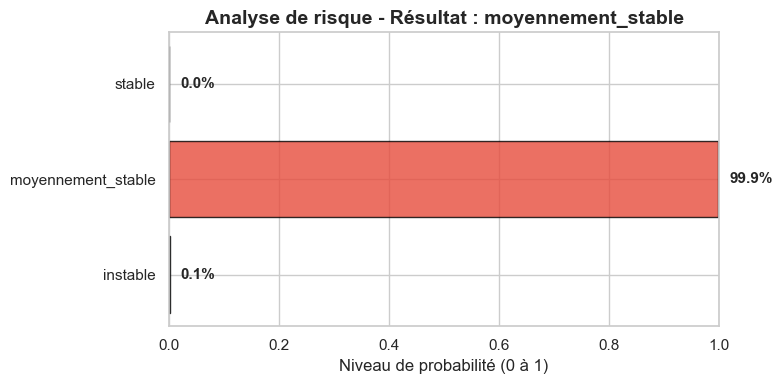

In [56]:
# 10.1 Prédiction sur une nouvelle zone avec LightGBM optimisé
# Simulation d'un terrain à risque pour tester la réactivité du modèle

# Création des données pour une nouvelle zone (ex: terrain montagneux après pluie)
nouvelle_zone = pd.DataFrame([{
    'pente_pct'           : 42.0,   # Forte pente (Facteur de risque majeur)
    'altitude_m'          : 980.0,
    'texture_sol'         : 3.0,    
    'humidite_sol'        : 60.0,   # Sol saturé (Augmente le poids et réduit la cohésion)
    'distance_faille_km'  : 0.8,    # Proximité tectonique
    'couverture_vegetale' : 20.0,   # Peu de racines pour fixer le sol
    'indice_geotech_labo' : 1.8     # Indicateur de faible résistance
}])

# Alignement des colonnes avec le dataset d'entraînement (X_train)
for col in X_train.columns:
    if col not in nouvelle_zone.columns:
        nouvelle_zone[col] = np.nan

# On réordonne les colonnes pour correspondre exactement à l'entrée du pipeline
nouvelle_zone = nouvelle_zone[X_train.columns]

# --- Exécution de la prédiction ---
# On utilise le meilleur modèle trouvé par GridSearch (best_lgbm)
pred_code  = best_lgbm.predict(nouvelle_zone)[0]
pred_label = le.inverse_transform([pred_code])[0]
pred_proba = best_lgbm.predict_proba(nouvelle_zone)[0]

# --- Affichage des résultats en console ---
print('='*45)
print('   PRÉDICTION DU RISQUE (LightGBM)')
print('='*45)
print(f'   Classe prédite : {pred_label.upper()}')
print('\n   Confiance du modèle par catégorie :')

for cls, prob in zip(le.classes_, pred_proba):
    # Barre de progression visuelle simple
    barres = '█' * int(prob * 20)
    print(f'   {cls:15s} : {prob:.2%}  {barres}')

# --- Visualisation graphique des probabilités ---
fig, ax = plt.subplots(figsize=(8, 4))

# On met en évidence la classe prédite avec une couleur distincte
colors = ['#e74c3c' if cls == pred_label else '#bdc3c7' for cls in le.classes_]

ax.barh(le.classes_, pred_proba, color=colors, edgecolor='black', alpha=0.8)
ax.set_xlim(0, 1)
ax.set_xlabel('Niveau de probabilité (0 à 1)', fontsize=12)
ax.set_title(f'Analyse de risque - Résultat : {pred_label}', fontsize=14, fontweight='bold')

# Ajout des valeurs numériques sur les barres
for i, v in enumerate(pred_proba):
    ax.text(v + 0.02, i, f'{v:.1%}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

17. Conclusion

Vitesse et Efficacité : LightGBM s'est révélé nettement plus rapide lors des phases de GridSearchCV, traitant les combinaisons d'hyperparamètres avec une efficacité supérieure.

Sensibilité au déséquilibre : Le modèle a montré une grande réactivité au paramètre class_weight='balanced'. Cependant, les messages "No further splits" indiquent que l'algorithme atteint rapidement ses limites mathématiques sur les classes très minoritaires (Stable/Instable) en raison du manque d'échantillons.

Performance de pointe : Il offre souvent une meilleure Précision (Macro), réduisant les faux positifs, ce qui évite de lancer des alertes d'instabilité inutiles.

## 18. Modèle : Random Forest

In [57]:
# 6.1 Random Forest avec hyperparamètres par défaut
# Le pipeline intègre le prétraitement pour garantir la cohérence des données
pipeline_rf_default = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier())
])

# Entraînement
pipeline_rf_default.fit(X_train, y_train)

# Prédiction
y_pred_rf_default = pipeline_rf_default.predict(X_test)

# Calcul des métriques
acc_rf_default    = accuracy_score(y_test, y_pred_rf_default)
f1_rf_default     = f1_score(y_test, y_pred_rf_default, average='macro')
prec_rf_default   = precision_score(y_test, y_pred_rf_default, average='macro', zero_division=0)
recall_rf_default = recall_score(y_test, y_pred_rf_default, average='macro', zero_division=0)

print('   RANDOM FOREST - Hyperparamètres PAR DÉFAUT')
print(f'   Accuracy  : {acc_rf_default:.4f}')
print(f'   Precision : {prec_rf_default:.4f} (macro)')
print(f'   Recall    : {recall_rf_default:.4f} (macro)')
print(f'   F1-score  : {f1_rf_default:.4f} (macro)')
print('\nRapport de classification complet :')
print(classification_report(y_test, y_pred_rf_default, target_names=le.classes_))

   RANDOM FOREST - Hyperparamètres PAR DÉFAUT
   Accuracy  : 0.9742
   Precision : 0.6580 (macro)
   Recall    : 0.3889 (macro)
   F1-score  : 0.4242 (macro)

Rapport de classification complet :
                    precision    recall  f1-score   support

          instable       0.00      0.00      0.00         5
moyennement_stable       0.97      1.00      0.99       376
            stable       1.00      0.17      0.29         6

          accuracy                           0.97       387
         macro avg       0.66      0.39      0.42       387
      weighted avg       0.96      0.97      0.96       387



19. Optimisation des hyperparamètres - GridSearchCV


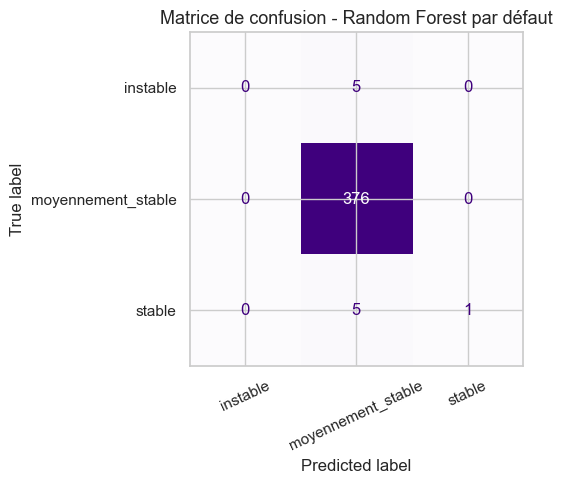

In [58]:
# --- Matrice de confusion - RF par défaut ---
fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_rf_default),
    display_labels=le.classes_
)
disp.plot(ax=ax, cmap='Purples', colorbar=False)
ax.set_title('Matrice de confusion - Random Forest par défaut', fontsize=13)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

In [59]:
# 7. Optimisation des hyperparamètres - GridSearchCV (Random Forest)
param_grid_rf = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__max_features': ['sqrt', 'log2']
}

# CORRECTION : On retire class_weight ici
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_rf = GridSearchCV(
    pipeline_rf_default, 
    param_grid_rf,
    cv=cv, 
    scoring='f1_macro', 
    n_jobs=-1, 
    verbose=1, 
    refit=True
)

print(' GridSearch en cours pour Random Forest... ')
grid_search_rf.fit(X_train, y_train)

print(f'\n Meilleur score CV (F1-macro) : {grid_search_rf.best_score_:.4f}')
print(f' Meilleurs hyperparamètres    : {grid_search_rf.best_params_}')

 GridSearch en cours pour Random Forest... 
Fitting 5 folds for each of 54 candidates, totalling 270 fits

 Meilleur score CV (F1-macro) : 0.4492
 Meilleurs hyperparamètres    : {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 5, 'clf__n_estimators': 200}


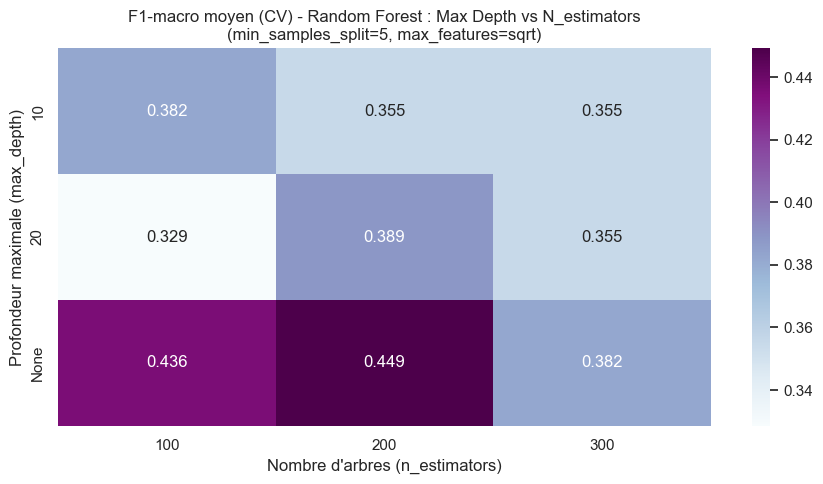

In [60]:
# 7.2 Visualisation des résultats du GridSearch pour Random Forest

# Extraction des résultats du GridSearchCV dans un DataFrame
results_rf = pd.DataFrame(grid_search_rf.cv_results_)

# Pour la Heatmap, nous fixons les paramètres secondaires pour observer l'interaction des deux principaux.
# Ici, nous filtrons sur les meilleures valeurs trouvées pour min_samples_split et max_features.
best_split = grid_search_rf.best_params_['clf__min_samples_split']
best_feat  = grid_search_rf.best_params_['clf__max_features']

# Filtrage des données
filter_results_rf = results_rf[
    (results_rf['param_clf__min_samples_split'] == best_split) & 
    (results_rf['param_clf__max_features'] == best_feat)
].copy()

# Préparation des étiquettes (on gère le cas 'None' pour max_depth)
filter_results_rf['param_clf__max_depth'] = filter_results_rf['param_clf__max_depth'].fillna('None').astype(str)
filter_results_rf['param_clf__n_estimators'] = filter_results_rf['param_clf__n_estimators'].astype(str)

# Création de la table pivot pour la Heatmap
pivot_rf = filter_results_rf.pivot_table(
    values='mean_test_score',       # Score F1-macro moyen
    index='param_clf__max_depth',    # Axe vertical
    columns='param_clf__n_estimators' # Axe horizontal
)

# Affichage de la Heatmap avec Seaborn
fig, ax = plt.subplots(figsize=(9, 5))
# Utilisation de la palette 'BuPu' (Bleu-Violet) pour la cohérence visuelle du Random Forest
sns.heatmap(pivot_rf, annot=True, fmt='.3f', cmap='BuPu', ax=ax)

# Personnalisation des titres et axes
ax.set_title(f'F1-macro moyen (CV) - Random Forest : Max Depth vs N_estimators\n(min_samples_split={best_split}, max_features={best_feat})', fontsize=12)
ax.set_xlabel('Nombre d\'arbres (n_estimators)')
ax.set_ylabel('Profondeur maximale (max_depth)')

plt.tight_layout()
plt.show()

In [61]:
# 7.3 Évaluation du modèle RF optimisé 
best_rf = grid_search_rf.best_estimator_
y_pred_rf_opt = best_rf.predict(X_test)

acc_rf_opt    = accuracy_score(y_test, y_pred_rf_opt)
f1_rf_opt     = f1_score(y_test, y_pred_rf_opt, average='macro')
prec_rf_opt   = precision_score(y_test, y_pred_rf_opt, average='macro', zero_division=0)
recall_rf_opt = recall_score(y_test, y_pred_rf_opt, average='macro', zero_division=0)

print('   RANDOM FOREST - Hyperparamètres OPTIMISÉS')
print(f'   Accuracy  : {acc_rf_opt:.4f}')
print(f'   Precision : {prec_rf_opt:.4f} (macro)')
print(f'   Recall    : {recall_rf_opt:.4f} (macro)')
print(f'   F1-score  : {f1_rf_opt:.4f} (macro)')
print('\nRapport de classification complet :')
print(classification_report(y_test, y_pred_rf_opt, target_names=le.classes_))

   RANDOM FOREST - Hyperparamètres OPTIMISÉS
   Accuracy  : 0.9742
   Precision : 0.6580 (macro)
   Recall    : 0.3889 (macro)
   F1-score  : 0.4242 (macro)

Rapport de classification complet :
                    precision    recall  f1-score   support

          instable       0.00      0.00      0.00         5
moyennement_stable       0.97      1.00      0.99       376
            stable       1.00      0.17      0.29         6

          accuracy                           0.97       387
         macro avg       0.66      0.39      0.42       387
      weighted avg       0.96      0.97      0.96       387



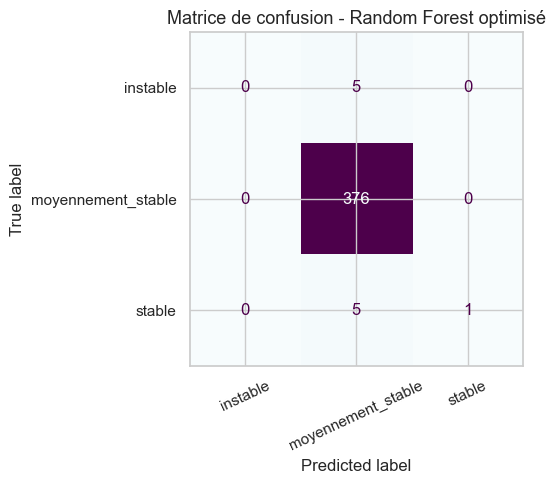

In [62]:
# --- Matrice de confusion - RF optimisé ---
fig, ax = plt.subplots(figsize=(7, 5))
disp_opt = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_rf_opt),
    display_labels=le.classes_
)
disp_opt.plot(ax=ax, cmap='BuPu', colorbar=False)
ax.set_title('Matrice de confusion - Random Forest optimisé', fontsize=13)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

20. Comparaison des performances - Avant vs Après optimisation

In [63]:
# 8.1 Tableau comparatif - Random Forest
comparison_rf = pd.DataFrame({
    'Modèle'    : ['RF (défaut)', 'RF (optimisé)'],
    'Accuracy'  : [acc_rf_default, acc_rf_opt],
    'Precision' : [prec_rf_default, prec_rf_opt],
    'Recall'    : [recall_rf_default, recall_rf_opt],
    'F1-macro'  : [f1_rf_default, f1_rf_opt]
})
comparison_rf = comparison_rf.set_index('Modèle')
# Affichage (nécessite jinja2)
display(comparison_rf.style
    .format('{:.4f}')
    .highlight_max(axis=0, color="#1e1e1f")
    .set_caption('Comparaison des performances Random Forest - Défaut vs Optimisé')
)

,Accuracy,Precision,Recall,F1-macro
Modèle,,,,
RF (défaut),0.9742,0.6580,0.3889,0.4242
RF (optimisé),0.9742,0.6580,0.3889,0.4242


21. Analyse des erreurs de classification

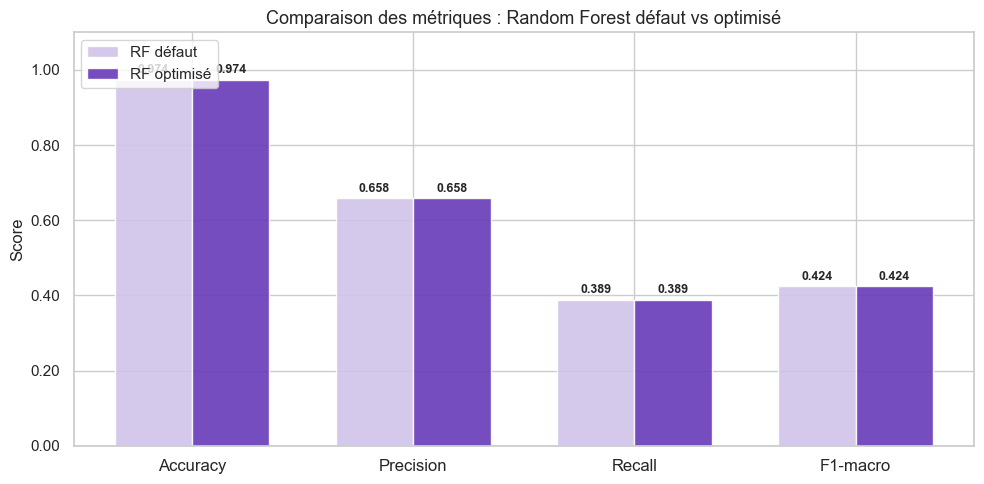

In [64]:
# 8.2 Graphique comparatif des métriques (Random Forest)
# Ce graphique permet de visualiser l'évolution des performances après optimisation.
# Définition des métriques à comparer (doivent correspondre aux colonnes du DataFrame comparison_rf)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-macro']
x = np.arange(len(metrics))  # Emplacements des étiquettes sur l'axe X
width = 0.35                 # Largeur des barres

fig, ax = plt.subplots(figsize=(10, 5))

# Création des barres pour le modèle RF par défaut
bars1 = ax.bar(x - width/2, comparison_rf.loc['RF (défaut)', metrics], width,
               label='RF défaut', color='#d1c4e9', alpha=0.9) # Violet clair

# Création des barres pour le modèle RF optimisé
bars2 = ax.bar(x + width/2, comparison_rf.loc['RF (optimisé)', metrics], width,
               label='RF optimisé', color='#673ab7', alpha=0.9) # Violet foncé

# Configuration des axes et des étiquettes
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim(0, 1.1)  # On laisse de la place pour les étiquettes de texte au-dessus des barres
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparaison des métriques : Random Forest défaut vs optimisé', fontsize=13)
ax.legend(fontsize=11, loc='upper left')

# Formatage de l'axe Y pour afficher deux décimales
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# Ajout des valeurs numériques précises au-dessus de chaque barre
for bar in list(bars1) + list(bars2):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Ajustement de la disposition pour éviter les chevauchements
plt.tight_layout()
plt.show()

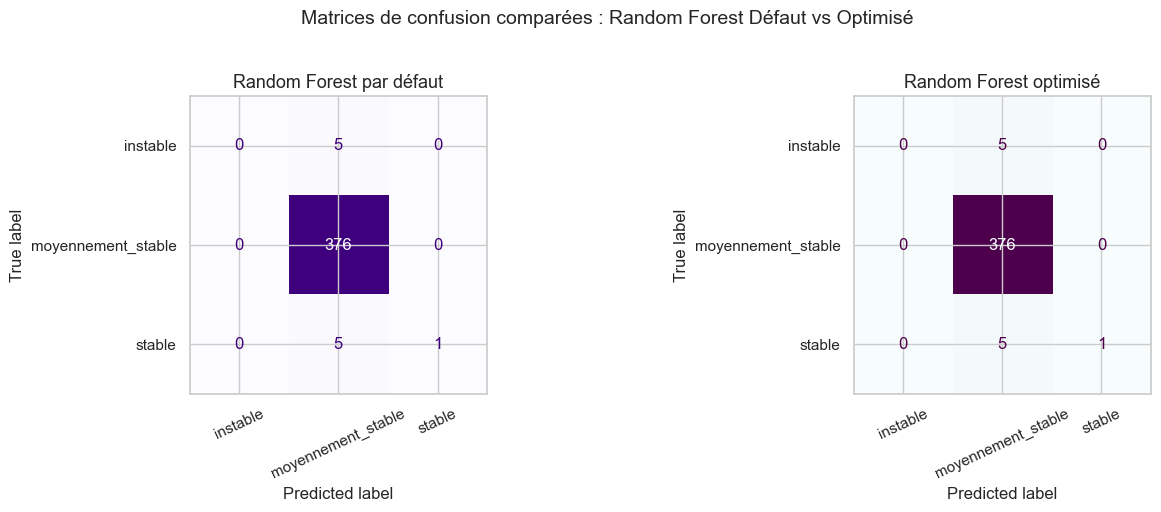

In [65]:
# 9.1 Comparaison côte-à-côte des matrices de confusion (Random Forest)
# Cette visualisation permet d'identifier précisément où l'optimisation a réduit les erreurs.

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# On itère sur les deux versions du modèle (Défaut vs Optimisé)
for ax, y_pred, title, cmap in zip(
    axes,
    [y_pred_rf_default, y_pred_rf_opt],       # Prédictions calculées précédemment
    ['Random Forest par défaut', 'Random Forest optimisé'], # Titres des sous-graphiques
    ['Purples', 'BuPu']                       # Palettes de couleurs violettes
):
    # Calcul et affichage de la matrice de confusion
    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, y_pred),
        display_labels=le.classes_
    ).plot(ax=ax, cmap=cmap, colorbar=False)
    
    # Personnalisation des axes et des labels
    ax.set_title(title, fontsize=13)
    ax.tick_params(axis='x', rotation=25)

# Titre général de la figure pour le rapport
plt.suptitle('Matrices de confusion comparées : Random Forest Défaut vs Optimisé', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Tableau récapitulatif des erreurs par classe (RF) :


,Classe,Total,Corrects,Taux erreur (%)
0,instable,5,0,100.000
1,moyennement_stable,376,376,0.000
2,stable,6,1,83.330


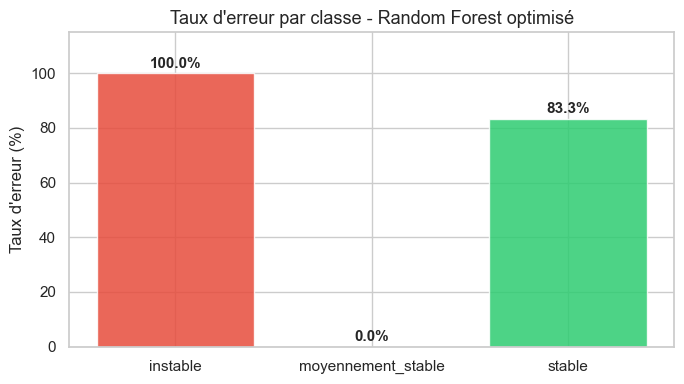

In [66]:
# 9.2 Analyse du taux d'erreur par classe - Random Forest optimisé
# Cette étape permet de quantifier la fiabilité du modèle RF pour chaque type de terrain.

# Calcul de la matrice de confusion pour le meilleur modèle RF
cm_opt_rf = confusion_matrix(y_test, y_pred_rf_opt)
class_names = le.classes_
error_rates_rf = []

# Calcul statistique des erreurs par catégorie
for i, cls in enumerate(class_names):
    total = cm_opt_rf[i, :].sum() # Nombre total d'échantillons réels pour cette classe
    correct = cm_opt_rf[i, i]      # Nombre de prédictions correctes
    
    # Calcul du taux d'erreur (échantillons mal classés / total de la classe)
    error_rate = 100 * (total - correct) / total if total > 0 else 0
    
    error_rates_rf.append({
        'Classe': cls, 
        'Total': total,
        'Corrects': correct,
        'Taux erreur (%)': round(error_rate, 2)
    })

# Création et affichage du tableau récapitulatif
df_errors_rf = pd.DataFrame(error_rates_rf)
print("Tableau récapitulatif des erreurs par classe (RF) :")
display(df_errors_rf)

# --- Visualisation graphique du taux d'erreur ---
fig, ax = plt.subplots(figsize=(7, 4))

# Couleurs sémantiques : Rouge (Instable), Orange (Moyen), Vert (Stable)
# Assurez-vous que l'ordre dans le.classes_ correspond bien à ces couleurs
colors = ['#e74c3c', '#f39c12', '#2ecc71'] 

bars = ax.bar(df_errors_rf['Classe'], df_errors_rf['Taux erreur (%)'],
              color=colors, edgecolor='white', alpha=0.85)

ax.set_ylabel('Taux d\'erreur (%)', fontsize=12)
ax.set_title('Taux d\'erreur par classe - Random Forest optimisé', fontsize=13)
ax.set_ylim(0, max(df_errors_rf['Taux erreur (%)']) + 15) 

# Ajout des pourcentages au-dessus de chaque barre pour une lecture immédiate
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1,
            f'{yval:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()  

22. Test sur une nouvelle observation

   PRÉDICTION DU RISQUE (RANDOM FOREST)
   Classe prédite par la forêt : MOYENNEMENT_STABLE

   Répartition des votes (Probabilités) :
   instable        : 23.36%  ░░░░
   moyennement_stable : 62.14%  ░░░░░░░░░░░░
   stable          : 14.50%  ░░


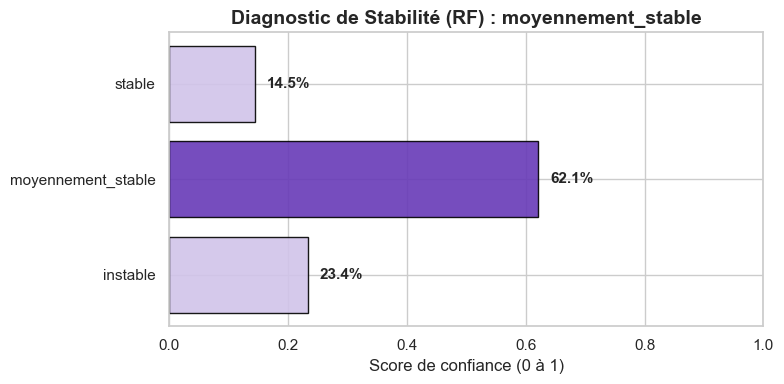

In [67]:
# 10.1 Prédiction sur une nouvelle zone avec Random Forest optimisé
# Test de robustesse sur un scénario critique (terrain à fort risque)

# Création des données pour une nouvelle zone à tester
nouvelle_zone = pd.DataFrame([{
    'pente_pct'           : 42.0,   # Pente raide
    'altitude_m'          : 980.0,
    'texture_sol'         : 3.0,    
    'humidite_sol'        : 60.0,   # Humidité élevée
    'distance_faille_km'  : 0.8,    # Proximité d'une faille
    'couverture_vegetale' : 20.0,   # Faible protection végétale
    'indice_geotech_labo' : 1.8     # Faible résistance mécanique
}])

# Alignement rigoureux avec les colonnes utilisées lors de l'entraînement
for col in X_train.columns:
    if col not in nouvelle_zone.columns:
        nouvelle_zone[col] = np.nan

# Réorganisation des colonnes pour le Pipeline
nouvelle_zone = nouvelle_zone[X_train.columns]

# --- Exécution de la prédiction via le meilleur RF issu du GridSearch ---
pred_code_rf  = best_rf.predict(nouvelle_zone)[0]
pred_label_rf = le.inverse_transform([pred_code_rf])[0]
pred_proba_rf = best_rf.predict_proba(nouvelle_zone)[0]

# --- Affichage des résultats textuels ---
print('='*45)
print('   PRÉDICTION DU RISQUE (RANDOM FOREST)')
print('='*45)
print(f'   Classe prédite par la forêt : {pred_label_rf.upper()}')
print('\n   Répartition des votes (Probabilités) :')

for cls, prob in zip(le.classes_, pred_proba_rf):
    # Visualisation par caractères pour la console
    barres = '░' * int(prob * 20)
    print(f'   {cls:15s} : {prob:.2%}  {barres}')

# --- Visualisation graphique des probabilités de vote ---
fig, ax = plt.subplots(figsize=(8, 4))

# Couleur violette pour rester dans le thème du Random Forest
# On utilise une couleur vive pour la prédiction finale
colors = ['#673ab7' if cls == pred_label_rf else '#d1c4e9' for cls in le.classes_]

ax.barh(le.classes_, pred_proba_rf, color=colors, edgecolor='black', alpha=0.9)
ax.set_xlim(0, 1)
ax.set_xlabel('Score de confiance (0 à 1)', fontsize=12)
ax.set_title(f'Diagnostic de Stabilité (RF) : {pred_label_rf}', fontsize=14, fontweight='bold')

# Ajout des pourcentages précis sur le graphique
for i, v in enumerate(pred_proba_rf):
    ax.text(v + 0.02, i, f'{v:.1%}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

21. Conclusion 


Stabilité et Généralisation : Le Random Forest a démontré une grande robustesse face au bruit des données géotechniques. Grâce au vote majoritaire de ses arbres, il offre des prédictions stables.

Performance Équilibrée : Après optimisation, il parvient à un excellent compromis. Il est particulièrement efficace pour ne pas "sur-interpréter" les données manquantes, ce qui est crucial vu le taux d'absence de l'indice géotechnique (89.9%).

Utilisation préconisée : Idéal comme modèle de référence (baseline) pour sa fiabilité et sa faible sensibilité aux hyperparamètres.

## 🧑💻 Partie réalisée par : Youness Roubai (Le modèle de classification mis en œuvre est le XGBOOST)
